---

<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# Balance de Energía Superficial - Modelo METRIC

**Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)**

Descripción:
- METRIC es un modelo de procesamiento de imágenes para calcular la ET como residuo del balance energético de la superficie.
- METRIC fue desarrollado por la Universidad de Idaho para su aplicación a imágenes de satélite Landsat con el fin de maximizar la resolución del producto ET (30 m).
- METRIC utiliza como base el proceso pionero de balance energético SEBAL desarrollado en los Países Bajos por Bastiaanssen et al..

Aplicación de referencia:
- [geeSEBAL en GitHub](https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js)

## Inicio

Pasos
1. Importar librerías
2. Importar área de estudio
3. Establecer parámetros de visualizaciones

In [1]:
# ------------------------------------------------
# Importando librerías utilizadas
# ------------------------------------------------

import ee          # Earth Engine Python API
ee.Initialize()

import os
import numpy as np
import math
import pandas as pd   

import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes
from geemap import cartoee
import cartopy.crs as ccrs

from pprint import pprint
import matplotlib.pyplot as plt

# Funciones en archivo Funciones.py
from funciones import *

In [2]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------

# import importlib 
# import sys

# importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
# from funciones import *    

In [2]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# Importar asset público: Distrito de Ferreñafe
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos') 
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
roi = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja 

# Importar shapefile de Áreas voladas (archivo en local)
ruta_ferrenafe = r'input/Ferreñafe_areas_2.shp'  

# Lectura como FeatureCollection con geemap
predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes, no relleno

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)  # Ver solo bordes, no relleno

type(predios_agricolas) # Comprobación

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# -------------------------------------------------------
# Parámetros de visualización de gráficas con matplotlib
# -------------------------------------------------------

plt.rcParams['font.family'] = 'serif'  #'serif', 'Arial'  # default es 'sans-serif'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

# =============================================================
# Inputs iniciales
# =============================================================

# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes seleccionadas
ids = [
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113',  # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129',  # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310',  # 3 - 03/10 - l8
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    # 'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
]

# Importar DEM SRTM
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

## Procesamiento

### Procesar ET

Productos y Rn de imagen 2022-03-10 procesada!

Coeficientes:
	a_coef: 1.6078423438627618
	b_coef: -37.25789695033866

Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,ET
max,29.774638,0.813376,1.824434,0.210209,691.382619,84.508916,1319.939279,174.969389,6.189763
mean,25.582867,0.694646,1.570804,0.157055,584.126280,55.007496,519.004578,10.114207,0.355959
median,25.418676,0.728591,1.644671,0.163518,579.528811,53.372950,498.144723,34.168844,1.140315
min,24.818607,0.057734,0.210231,0.038788,530.186712,42.006730,381.883072,-835.501513,-29.696157
mode,25.326462,0.759826,1.714635,0.163518,574.570110,51.623072,481.985413,69.918414,2.385530
stdDev,0.602802,0.119466,0.255204,0.030651,26.615475,7.362497,106.650385,114.670581,4.066491


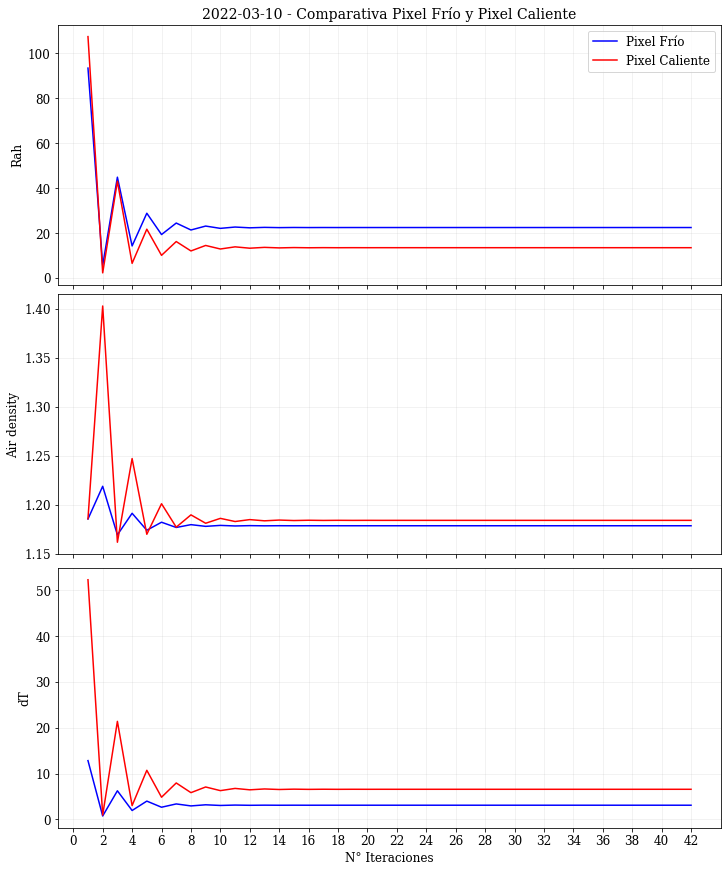

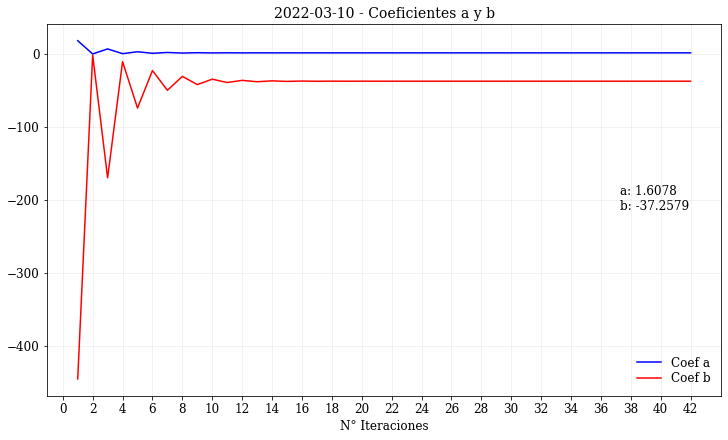

In [4]:
# =============================================================
# Inputs iniciales
# =============================================================

index = 2 # Imagen Landsat: 0 1 Enero, 2 Marzo, 3 Junio 
lai_method = 2  # 0: Savi con l=0.1, 1: Savi con L=0.5, 2: Relación NDVI - IAF 

save_files = False
plot_balance_comp = False

# =============================================================
# Radiación Neta Rn
# =============================================================

img_id = ids[index] 
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas)

# Fechas 
img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()
fecha = img_date_format2

ruta = f'output/{fecha}' # <--------- Establecer ruta de resultados

# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=lai_method) # roi: Ferreñafe

print(f'Productos y Rn de imagen {img_date_format2} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

# =============================================================
# Valores de pixel frío y caliente
# =============================================================

list_weather_st = [
    [1.6, 0.3],
    [1.6, 0.69],
    [3.2, 0.53],
    [1.6, 0.46]
] # km/h

filtrado_ws, filtrado_et = list_weather_st[index]

list_coords_pixf = [
    [-79.78527, -6.598056], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.78472, -6.598345], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984], # 2 '2022-03-10' n1: 50 n2: 5
    [-79.778737, -6.604828] # 3 '2022-06-14' n1: 50 n2: 5
]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 50 n2: 70
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 3 n2: 80 
    [-79.784729, -6.595629]  # 3 '2022-06-14' n1: 10 n2: 80 
]

pixc_coord = list_coords_pixc[index]
pixc_ee_coord = ee.Geometry.Point(pixc_coord)

pix_h_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

# =============================================================
# Flujo de calor sensible H - Proceso Iterativo
# =============================================================

n_iteraciones = 40

iteracion_output = parte_iterativa(n_iteraciones, pix_c_values, pix_h_values, filtrado_ws, filtrado_et)

# Resultados del proceso iterativo
dict_pix_f_resultados = iteracion_output['dict_pix_f_resultados']
dict_pix_c_resultados = iteracion_output['dict_pix_c_resultados']
resultados_coef = iteracion_output['list_coef_resultados']
u_200 = iteracion_output['u_200']
list_stability_result = iteracion_output['list_stability_resultados']

# Coeficientes a y b
coefs_a = resultados_coef[0] 
coefs_b = resultados_coef[1]
print('\nCoeficientes:')
print(f'\ta_coef: {coefs_a[-1]}')
print(f'\tb_coef: {coefs_b[-1]}')

# ==============================================================
# - Gráfico 1: Pixel frío y caliente durante el proceso iterativo

# Plot Pixel Frío
# get_grafica_iteracion(fecha, dict_pix_f_resultados, 'Pixel Frío', 'blue', n_iteraciones, save_fig=save_files)
# plt.close()

# Plot Pixel Caliente
# get_grafica_iteracion(fecha, dict_pix_c_resultados, 'Pixel Caliente', 'red', n_iteraciones, save_fig=save_files)
# plt.close()

# ==============================================================
# - Gráfico 2: Gráfico 1 combinado

x_values = np.arange(1, n_iteraciones+2+1)

# Desarrollo de gráfica
fig, axs = plt.subplots(3,1, figsize=(10,12), layout='constrained', sharex=True)

title_name = f'{fecha} - Comparativa Pixel Frío y Pixel Caliente'
axs[0].set_title(title_name, fontsize='14')
ylabels = ['Rah', 'Air density', 'dT']

list_variables = ['r_ah', 'air_dens_p', 'dT0']

for n in range(0, 2+1):
    
    variable = list_variables[n]
    axs[n].plot(x_values, dict_pix_f_resultados[variable], 'b-', label='Pixel Frío')#, color='blue')
    axs[n].plot(x_values, dict_pix_c_resultados[variable], 'r-', label='Pixel Caliente')#, color='red')
    
    axs[n].set(xticks=np.arange(0, n_iteraciones+3, step=2), ylabel=ylabels[n])
    axs[n].grid(alpha=0.2)

axs[0].legend(fontsize='12')
axs[2].set_xlabel('N° Iteraciones');

# Guardar
if save_files is True:
    nombre_img = f'{fecha}-Comparativa Pixeles.jpg'
    fig.savefig(ruta+nombre_img) #,dpi=400);

# ==================================================================
# - Gráfico 3: Coeficientes de selección de pixeles frío y caliente

fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.plot(x_values, coefs_a, label='Coef a', color='blue')
ax.plot(x_values, coefs_b, label='Coef b', color='red')

title_name = f'{fecha} - Coeficientes a y b' 
ax.set(title=title_name, xlabel='N° Iteraciones', xticks=np.arange(0, n_iteraciones+2+1, step=2))

texto = f'a: {round(coefs_a[-1], 4)}\nb: {round(coefs_b[-1], 4)}'
ax.text(0.85, 0.5, s=texto, transform=ax.transAxes, fontsize=12)

ax.legend(fontsize=12, frameon=False, labelspacing=0.2, loc='best')
ax.grid(alpha=0.2)

# Guardar
if save_files is True:
    nombre_img = f'{title_name}.jpg'
    plt.savefig(ruta+nombre_img) #, dpi=400);

# =============================================================
# Balance de energía: LE = Rn - G - H
# =============================================================

# Corrección de H
img_H = get_H_corregido(img_productos_clipped, iteracion_output)
img_H_stats = get_stats(img_H, predios_agricolas, 30)

# Componentes de balance de energía
img_Rn = R_n.select('R_n').clip(predios_agricolas)

img_tempK = img_productos_clipped.select('Ts_k')
img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                             {'Ts_K': img_tempK,
                              'albedo': img_productos_clipped.select('albedo'),
                              'NDVI': img_productos_clipped.select('NDVI')}).multiply(R_n.select('R_n'))

# Balance de Energía
img_LE = img_Rn.expression('Rn - G - H',
                           {'Rn': img_Rn,
                            'G': img_G,
                            'H': img_H})

# Unir los componentes en una sola imagen
img_final = ee.Image([img_Rn, img_G, img_H, img_LE]).rename(['0_Rn', '1_G', '2_H', '3_LE'])
img_final_stats = get_stats(img_final, predios_agricolas, 30)
img_final_stats_df = pd.DataFrame.from_dict(img_final_stats, orient='index', dtype='float') # .round(3)

# =============================================================
# Evapotranspiración del cultivo ETinst (mm/hr y mm/d)
# =============================================================

# ET (mm/hr)
img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET')

# ET (mm/día)
img_ET_inst = img_ET_inst.multiply(24) # mm/dia

# Estadísticas
img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)

# =============================================================
# Resultados del procesamiento
# =============================================================

dfs = [img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']], img_final_stats_df, img_ET_inst_stats_df]
df_stats = pd.concat(dfs, axis=1)

print('\nResultados:')
display(df_stats)

if save_files is True:
    df_stats.to_csv(ruta + f'{fecha}_resultados.csv')

### Descarga de mapas `.tif`

In [ ]:
# Descarga de archivos .tif por fecha
variables = ['NDVI', 'LAI', 'Ts_c', 'albedo']

for variable in variables:
    image = img_productos_clipped.select(variable)
    geemap.ee_export_image(
        image,
        filename=f'output/tif2/{fecha}_{variable}.tif',
        region=predios_agricolas.geometry(),
        scale=30,
        file_per_band=False
    )

### Elaboración de gráficas

In [14]:
# Diccionarios de visualización
vis_params_ndvi = {
    'min': 0, 
    'max': 1,  
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn') # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('afmhot')  
}

vis_params_ts = {
    'min': 15, #img_productos_dict['min']['Ts_c'],
    'max': 35, #img_productos_dict['max']['Ts_c'],
    'palette': cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': 2, 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

In [19]:
def verMapa(img, vis_params, label):
    Map = geemap.Map()
    Map.centerObject(predios_agricolas, 16)
    Map.addLayer(img, vis_params, label)
    Map.add_colorbar(vis_params, orientation='vertical', label=label)
    return Map

#### NDVI

In [20]:
img = img_productos_clipped.select('NDVI')
verMapa(img, vis_params_ndvi, 'NDVI')

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

#### IAF

In [23]:
img = img_productos_clipped.select('LAI')
verMapa(img, vis_params_lai, 'IAF')

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

####  Albedo

In [21]:
img = img_productos_clipped.select('albedo')
verMapa(img, vis_params_alb, 'Albedo')

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

#### Temperatura de superficie

In [25]:
img = img_productos_clipped.select('Ts_c')
verMapa(img, vis_params_ts, 'Ts_c')

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

#### Radiación Neta

In [ ]:
img_final = ee.Image([img_Rn, img_G, img_H, img_LE]).rename(['0_Rn', '1_G', '2_H', '3_LE'])

In [29]:
vis_Rn = {'min': 
#           300, 
          img_final_stats['min']['0_Rn'],
          'max': 
#           700, 
          img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('RdYlGn_r')}

In [30]:
img = img_final.select('0_Rn')
verMapa(img, vis_Rn, 'Rn')

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

por ordenar ...

## Balance de Energía Superficial (por simplificar)

En esta sección se desarrollará los 3 componentes de la ecuación de balance de energía superficial:
- Radiación Neta $R_n$
- Flujo de calor del suelo $G$
- Flujo de calor sensible del aire $H$

Tendremos como valores input imágenes satelitales Landsat 8 y 9, así como datos meteorológicos.



Reporte con imágenes Landsat 8 y 9 unidos con sus respectivos datos de Evapotranspiración horaria y velocidad de viento de la estación meteorológica INIA Vista Florida.

### Radiación Neta $R_n$

The net radiation flux at the surface ($R_n$) represents the actual radiant energy available at the surface.

$$
R_n = R_{S\downarrow} - \alpha R_{S\downarrow} + R_{L\downarrow} - R_{L\uparrow} - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
\text{Net surface radiation} = \text{gains} - \text{losses}
$$

Dónde: 
- $R_n \;$ : Flujo de radiación neta $[W/m^2]$
- $\alpha \;\;\;\;$ : Albedo de superficie $[-]$
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0 \;\;\;$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

El término $(1- \epsilon_0)R_{L\downarrow}$ representa la fracción de radiación entrante de onda larga (incoming long-wave radiation) reflejada desde la superficie.

In [5]:
# 8 Imágenes seleccionadas
ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

In [ ]:
# Imagen Landsat seleccionada por index
img_id = ids[1] # 3 para Marzo, 7 para Junio
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas).blend(predios_vis)

img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=1) # roi: Ferreñafe

print(f'Rn de imagen {img_date_format2} procesada!')

# Producir tabla con valores de los flujos [W/m^2] necesarios para obtener Radiación Neta 
print('\nR_n_stats_df')
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index')#.round(2)
display(R_n_stats_df) 

# Producir tabla de estadísticos sobre los productos elaborados
print('img_prod_stats_df')
img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index', dtype='float')#.round(2)
display(img_prod_stats_df)

img_prod_stats_df.to_csv(f'{img_date_format2}_stats.csv')

In [89]:
# Resultados listos para copiar y pegar a word
print(img_date_format2+'\n')

# Sin redondear
col1 = img_prod_stats['mean']
col2 = img_prod_stats['stdDev']

varlist = ['NDVI', 'LAI', 'albedo']

print('Sin redondear')
for var in varlist:
    result1 = str(col1[var])+' ± '+ str(col2[var])
    print(result1)
print(str(R_n_stats['mean']['R_n'])+' ± '+ str(R_n_stats['stdDev']['R_n']))

# Con redondeo a 2 decimales
print('\nCon redondeo')
df = img_prod_stats_df.round(2)
for var in varlist:
    result1 = str(df[var]['mean']) +' ± '+ str(df[var]['stdDev'])
    print(result1)
df_rn = R_n_stats_df.round(2)
print(str(df_rn['R_n']['mean'])+' ± '+ str(df_rn['R_n']['stdDev']))

2022-06-14

Sin redondear
0.2643330411326045 ± 0.08928601305490091
0.6515682424674701 ± 0.19073278108787856
0.1908679116255491 ± 0.04276507115045371
444.7422556007581 ± 29.522093999532725

Con redondeo
0.26 ± 0.09
0.65 ± 0.19
0.19 ± 0.04
444.74 ± 29.52


In [17]:
# geemap.ee_export_image(
#     img_productos, 
#     filename=f'{img_date_format2}_productos.tif', scale=30, region=predios_agricolas.geometry(), file_per_band=True
# )

Generating URL ...
Please wait ...
Data downloaded to C:\Users\usuario\Documents\00-notebooks-2022


In [ ]:
# Notar
print(type(img_prod_stats['max']['LAI'])) # float
print(type(img_prod_stats_df['LAI']['max'])) # numpy.float64

#### Prueba: Obtener gráficas de cada variable

Basado en las rampas de colores usadas en la aplicación [EEFLUX](http://eeflux-level1.appspot.com/):
- Temperatura Superficial ![](http://eeflux-level1.appspot.com/css/lst_legend.png)
- Albedo ![](http://eeflux-level1.appspot.com/css/albedo_legend.png)
- NDVI ![](http://eeflux-level1.appspot.com/css/ndvi_legend.png)
- ETrF ![](http://eeflux-level1.appspot.com/css/etrf_legend.png)
- EToF ![](http://eeflux-level1.appspot.com/css/etof_legend.png)
- Actual ET (mm/day) ![](http://eeflux-level1.appspot.com/css/eta_legend.png)

Para identificar cada color se puede usar el siguiente [enlace](https://www.ginifab.com/feeds/pms/pms_color_in_image.php).

In [ ]:
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# Revertir lista
# https://datagy.io/python-reverse-list/s

# help(cmp)
# cmp.plot_colormaps()
# cmp.list_colormaps()

##### Prueba 1: Generando una sola gráficas

Generar gráfica de prueba.

In [ ]:
# Generar 
# for id_ in ids:
# Imagen Landsat
variable = 'Rn'
img_id = ids[3]
landsat_id = img_id[11:12]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)

img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
# img_productos.bandNames().getInfo() 
# ['NDVI', 'LAI', 'albedo', 'Ts_k', 'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 'slope']
img_ndvi = img_productos.select('NDVI')
# img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
# img_Ts_K = img_productos.select('Ts_k')

# cos_theta_rel = img_productos.select('cos_theta')
# t_sw = img_productos.select('t_sw')
# e_0  = img_productos.select('e_0')

print(f'Rn de imagen {img_date_format1} procesada!')


# Estadisticas
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)

display(R_n_stats_df)

In [ ]:
# R_n
vis_params_R_n = {'min': R_n_stats['min']['R_n'],
                  'max': R_n_stats['max']['R_n'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

print(f"Rangos: {vis_params_R_n['min']} - {vis_params_R_n['max']}")

image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
vis_params = vis_params_R_n
variable = 'Rn'
title_map = f'{variable}\n{img_date_format1}'
label = '$[\; W/m^2 \;]$'
ruta = f'{variable}_{img_date_format2}_L{landsat_id}'

get_grafica_cartoee_color(image, 
                          vis_params, 
                          text=title_map, 
                          label=label)#,save_fig=ruta)

-----

##### Prueba 2: Generando estadísticas de las imágenes en id

Generando estadísticas de cada imagen.

In [15]:
for id_ in ids:

    # Imagen Landsat
    img_id = id_
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date()
    img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
    img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')
    img_Ts_c = img_productos.select('Ts_c')
    # img_Ts_K = img_productos.select('Ts_k')

    # cos_theta_rel = img_productos.select('cos_theta')
    # t_sw = img_productos.select('t_sw')
    # e_0  = img_productos.select('e_0')

    print(f'Procesando Rn de imagen {img_date_format1}...')
    
    
    # Estadisticas --------------------------------------------------------------------------------
    
    R_n_stats = get_stats(R_n, predios_agricolas, 10)
    R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

    img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
    img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)
    
    # Guardar dataframe
    # img_prod_stats_df.to_csv(f'Estadisticas_{img_date_format2}.csv')
    
    # Mostrar dataframe
#     display(R_n_stats_df)
    print(f"Rangos min-max: {R_n_stats_df['R_n']['min']} - {R_n_stats_df['R_n']['max']}")
#     nombre_csv = f'R_n_stats_{img_date_format2}.csv'
#     R_n_stats_df.to_csv(nombre_csv)
#     print(f"R_n min-max: {R_n_stats_df['R_n'].min()} - {R_n_stats_df['R_n'].max()}")
#     display(img_prod_stats_df)

Procesando Rn de imagen 12-12-2021...
Rangos min-max: 516.92 - 706.96
Procesando Rn de imagen 13-01-2022...
Rangos min-max: 531.81 - 703.83
Procesando Rn de imagen 29-01-2022...
Rangos min-max: 534.24 - 691.81
Procesando Rn de imagen 10-03-2022...
Rangos min-max: 530.02 - 692.1
Procesando Rn de imagen 03-04-2022...
Rangos min-max: 517.27 - 651.47
Procesando Rn de imagen 21-05-2022...
Rangos min-max: 401.31 - 539.15
Procesando Rn de imagen 29-05-2022...
Rangos min-max: 369.93 - 555.36
Procesando Rn de imagen 14-06-2022...
Rangos min-max: 350.47 - 522.32


##### Prueba 3: Generando gráficas de las imágenes en id

Generando gráficas de cada variable para cada imagen.

In [9]:
# 8 Imágenes seleccionadas
ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

Procesando Rn de imagen 12-12-2021...


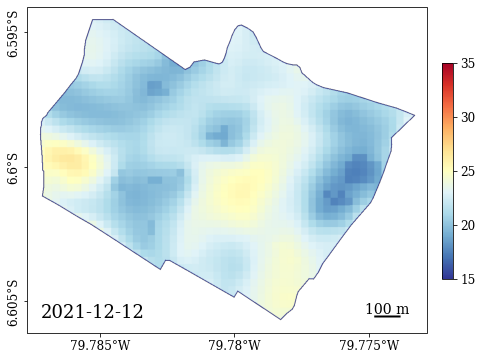

Procesando Rn de imagen 13-01-2022...


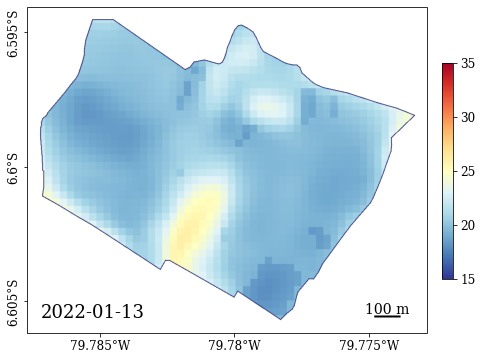

Procesando Rn de imagen 29-01-2022...


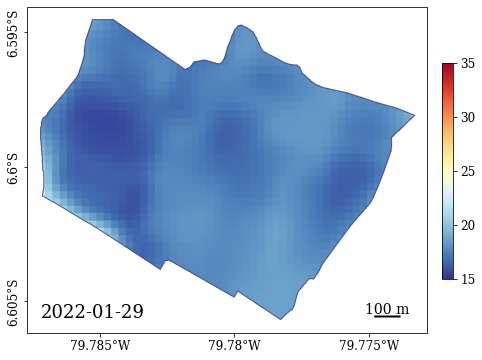

Procesando Rn de imagen 10-03-2022...


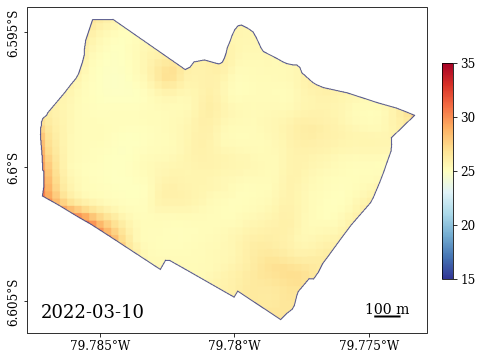

Procesando Rn de imagen 03-04-2022...


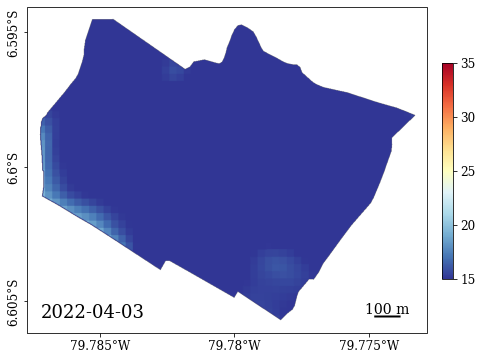

Procesando Rn de imagen 21-05-2022...


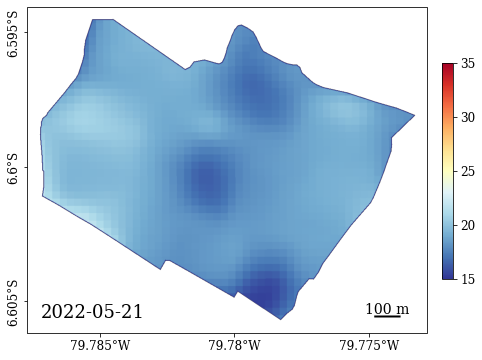

Procesando Rn de imagen 29-05-2022...


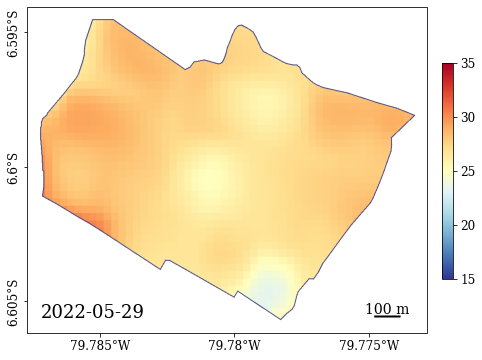

Procesando Rn de imagen 14-06-2022...


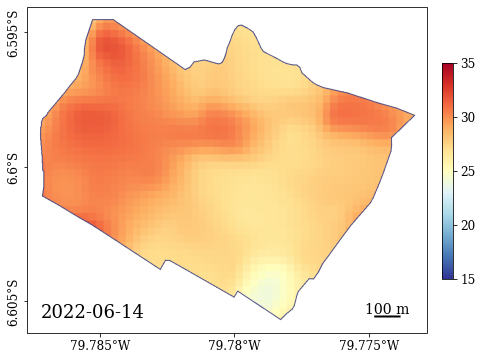

In [185]:
# Inputs iniciales

for id_ in ids:

    # Imagen Landsat
    img_id = id_
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date()
    img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
    img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')
    img_Ts_c = img_productos.select('Ts_c')
    # img_Ts_K = img_productos.select('Ts_k')

    # cos_theta_rel = img_productos.select('cos_theta')
    # t_sw = img_productos.select('t_sw')
    # e_0  = img_productos.select('e_0')

    print(f'Procesando Rn de imagen {img_date_format1}...')
    
    
    # Estadisticas --------------------------------------------------------------------------------
    
    R_n_stats = get_stats(R_n, predios_agricolas, 10)
    R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

    img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
    img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)

    
    # R_n --------------------------------------------------------------------------------------
    
#     variable = 'Rn'
#     vis_params_R_n = {'min': 0, #R_n_stats['min']['R_n'],
#                       'max': 700, #R_n_stats['max']['R_n'], 
#                       'palette': rn_cmp_r}#cmp.get_palette('gist_rainbow_r')} # gist_rainbow, RdYlGn_r

#     image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
#     vis_params = vis_params_R_n
#     variable = 'R_n'
#     label = '$[\; W/m^2 \;]$'
#     title_map = f'{img_date_format1}\n{variable}'
#     ruta = f'{variable}_{img_date_format2}_L{landsat_id}'
    
#     print(f"R_n min-max: {R_n_stats_df['R_n'].min()} - {R_n_stats_df['R_n'].max()}")
    
#     get_grafica_cartoee_color(image, vis_params, text=title_map, label=label, save_fig=None)

    
    # Albedo --------------------------------------------------------------------------------------
    
#     vis_params_alb = {'min': 0, #img_prod_stats['min']['albedo'], 
#                       'max': 0.4, #img_prod_stats['max']['albedo'], 
#                       'palette': cmp.get_palette('turbo_r')} #cmp.get_palette('afmhot')} # RdYlGn_r, albedo_cmap

#     image = img_albedo.clip(predios_agricolas).blend(predios_vis)
#     # image = image.updateMask(image.lte(0.22).And(image.gt(0.17)))

#     vis_params = vis_params_alb
#     variable = 'Albedo'
#     label = '$[\; - \;]$'
#     title_map = img_date_format2
#     ruta = f'{variable}/{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, text=title_map, label=label, save_fig=ruta)

    
#     # Temperatura Superficial -------------------------------------------------------------------
    
    vis_params_ts = {'min': 15, # img_prod_stats['min']['Ts_c'],
                     'max': 35, # img_prod_stats['max']['Ts_c'],
                     'palette': cmp.get_palette('RdYlBu_r')}

    image = img_Ts_c.clip(predios_agricolas).blend(predios_vis)
    vis_params = vis_params_ts
    variable = 'Ts'
    label = 'Ts (°C)'
    title_map = img_date_format2 # f'{variable}\n{img_date_format1}'
    ruta = f'{variable}/{variable}_{img_date_format2}_L{landsat_id}'

    get_grafica_cartoee_color(image, vis_params, text=title_map, label=label, save_fig=ruta)

    
    # NDVI --------------------------------------------------------------------------------------
    
#     vis_params_ndvi = {'min': -0.2, 
#                        'max': 1, # img_prod_stats['max']['NDVI'], 
#                        'palette': ndvi_cmap} #cmp.get_palette('ndvi')}

#     image = img_ndvi.clip(predios_agricolas).blend(predios_vis)

# #     if img_prod_stats['min']['NDVI'] < 0:
#       # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
# #       image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

#     vis_params = vis_params_ndvi
#     variable = 'NDVI'
#     title_map = f'{img_date_format2}'
#     label = '$[\; - \;]$'
#     ruta = f'{variable}/{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, text=title_map, label=label, save_fig=ruta)

    
#     # LAI --------------------------------------------------------------------------------------
    
#     vis_params_lai = {'min': -0.2,#img_prod_stats['min']['LAI'], 
#                       'max': 2,#img_prod_stats['max']['LAI'], 
#                       'palette': ndvi_cmap}#cmp.get_palette('RdYlGn')}
    
#     image = img_lai.clip(predios_agricolas).blend(predios_vis)

#     # if img_prod_stats['LAI']['min'] < 0:
#       # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
#       # image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos
    
#     vis_params = vis_params_lai
#     variable = 'LAI'
#     title_map = img_date_format2
#     label = '$[\; - \;]$'
#     ruta = f'{variable}/{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, text=title_map, label=label, save_fig=ruta)
    

**Recortando las imágenes generadas**

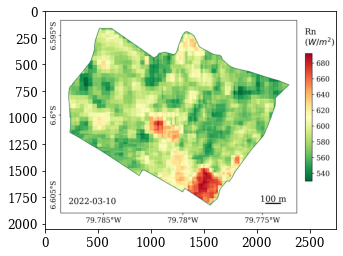

In [32]:
# Inspeccionando el recorte de imagenes
import matplotlib.image as mpimg

# Visualizar imagen
path = r'C:\Users\usuario\Documents\00-notebooks-2022\images\cartoee\Rn'
img_path = 'Rn_2022-03-10.jpg'
img = mpimg.imread(path+'\\'+img_path)

# Eliminar espacios en blanco: Recorte
# img_clip = mpimg.imread(path+'\\'+img_path)#[250:250+2000,340:350+2450] # NDVI
# img_clip = mpimg.imread(path+'\\'+img_path)[200:2250,300:3075] # Elimina la barra de color
# img_clip = img[200:2250,300:2750] # Elimina la barra de color, figsize=(8,6)
img_clip = img[200:2250,300:3050] # No elimina la barra de color, figsize=(8,6)
# plt.imsave(path+'\\'+'recorte.jpg', img_clip)

# Elimiinar todo y dejar solo la barra de color
# img_clip = img[650:3600-750,4050:4500] # figsize=(12,9)
#img_clip = img[850:img.shape[0]-1050, img.shape[1]-1000:img.shape[1]-500] # figsize=(16,12)
# plt.imsave(path+'\\'+'barra_recortada.jpg', img_clip)

plt.imshow(img_clip);

In [166]:
# Prueba: Recortar las imágenes de una carpeta en específico
list_imgs = os.listdir(path)
# list_imgs

plt.figure(1)
for i in range(len(list_imgs)):
    img_path = path+"\\"+list_imgs[i]
    # img = mpimg.imread(img_path)[30:335,:] # Con grilla
    # img = mpimg.imread(img_path)[0:330,:] # Sin grilla
    # img = mpimg.imread(img_path)[30:410,60:500] # Imagenes sin barra, 8x6
    # img = mpimg.imread(img_path)[250:250+2000,340:350+2450] # Imagenes sin barra, 8x6 400dpi
    # img = mpimg.imread(img_path)[200:2250,300:3075] # Imagenes con barra, LAI 8x6 400dpi
    img = mpimg.imread(img_path)[200:2250,300:2750] # Imagenes sin barra, LAI 8x6 400dpi
    plt.imsave(img_path+'_recortado.jpg', img) # https://www.delftstack.com/howto/numpy/save-numpy-array-as-image/

<Figure size 432x288 with 0 Axes>

Nota: Usar solo para recortar imágenes que lo necesiten y no olvidar borrar el archivo `phototumb.db`. Es posible mejorar la búsqueda de archivos .jpg con regex creo o glob (revisar curso de python de geomatica ambiental)

#### Prueba: Elaboración de boxplot

Matplotlib - Boxplot:
- https://matplotlib.org/stable/gallery/index.html#statistics
- https://matplotlib.org/stable/gallery/statistics/boxplot.html#sphx-glr-gallery-statistics-boxplot-py

Ojo con los ee.Reducer:
- [Reducer / Statistics of an Image Region - Pixels in the region](https://developers.google.com/earth-engine/guides/reducers_reduce_region#pixels-in-the-region)
- [Reducer / Weighted Reductions](https://developers.google.com/earth-engine/guides/reducers_weighting): By default, reducers applied to imagery weight the inputs according to the mask value. This is relevant in the context of fractional pixels created through operations such as clip(). Adjust this behavior by calling unweighted() on the reducer. Using an unweighted reducer forces all pixels in the region to have the same weight. 
- [ee.Reducer.median](https://developers.google.com/earth-engine/apidocs/ee-reducer-median)
- [ee.Reducer.mean](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)

1. Extraer valores con `image.reduceRegions(ee.Reducer.toList())` y almacenarlos en una lista
2. Con Matplotlib usamos .boxplot(lista)

In [ ]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

lista_dates = []
lista_ndvi_boxplot = []
lista_savi_boxplot = []
lista_lai_boxplot = []
lista_albedo_boxplot = []

lista_boxplot = []

for id in ids:
    
    # Imagen Landsat
    img_id = id
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    lista_dates.append(img_date)

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')

    # Convertir ee.Image a numpy.array
    ndvi_list_values = img_ndvi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('NDVI').getInfo()
    savi_list_values = img_savi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('SAVI').getInfo()
    lai_list_values  = img_lai.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('LAI').getInfo()
    albedo_list_values = img_albedo.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('albedo').getInfo()

    # ndvi_array = np.array(ndvi_list_values)
    # lista_prueba = ndvi_array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

    lista_ndvi_boxplot.append(ndvi_list_values)
    lista_savi_boxplot.append(savi_list_values)
    lista_lai_boxplot.append(lai_list_values)
    lista_albedo_boxplot.append(albedo_list_values)

    print(f'Rn de imagen {img_date} procesada!') 

In [ ]:
# Visualización de Boxplot con Matplotlib
title_boxplot = 'Boxplot'
lista_boxplot = lista_albedo_boxplot 
# lista_ndvi_boxplot, lista_savi_boxplot, lista_lai_boxplot, lista_albedo_boxplot

# Boxplot NDVI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

axs[0].boxplot(lista_boxplot, labels=lista_dates)
axs[0].set_title(title_boxplot)
axs[0].axhline(0, color='k', ls='--', lw=1)

axs[1].boxplot(lista_boxplot, labels=lista_dates, showfliers=False)
axs[1].set_title(f'{title_boxplot} showfliers=False')
axs[1].axhline(0, color='k', ls='--', lw=1)

# axs[0].set_ylim(top=1)
# axs[1].set_ylim(top=1)

fig.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
# Boxplot grupal
lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, 
                    lista_lai_boxplot, lista_albedo_boxplot]
lista_parametros_titles = ['NDVI', 'SAVI', 'LAI', 'Albedo']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axs = axs.flatten()

for i, lista in enumerate(lista_parametros):
    axs[i].boxplot(lista,
                   labels=lista_dates,
                   showfliers=True)
    axs[i].set_title(lista_parametros_titles[i]+' Boxplot')
    axs[i].axhline(0, color='k', ls='--', lw=1)
#     axs[i].set_ylim(top=1)

fig.subplots_adjust(wspace=0.1)
plt.show()

**Boxplot con seaborn**

Boxplot:
- https://seaborn.pydata.org/generated/seaborn.boxplot.html

Para control de gráfico
- https://seaborn.pydata.org/tutorial/aesthetics.html
- https://stackoverflow.com/questions/58476654/how-to-remove-or-hide-x-axis-labels-from-a-seaborn-matplotlib-plot
- https://python-graph-gallery.com/33-control-colors-of-boxplot-seaborn

Links para customizar el boxplot:
- https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
- https://matplotlib.org/stable/gallery/text_labels_and_annotations/legend_demo.html
- https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

In [ ]:
# Creamos una función que genere dataframes
def prepare_df_vertical(lista_escogida, lista_title):
    
    lista_pd = []
    
    for i, lista in enumerate(lista_escogida):
        prueba = pd.DataFrame(list(zip(lista)), columns=['Valores'])
        prueba['Fecha'] = lista_dates[i]
        prueba['Tipo'] = lista_title
        lista_pd.append(prueba)

    df = pd.concat(lista_pd)
    
    return df

In [ ]:
# Una vez creado la función, generar dataframes y luego concatenarlos entre si
# lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, lista_lai_boxplot, lista_albedo_boxplot]
lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, lista_albedo_boxplot]

# lista_parametros_titles = ['NDVI', 'SAVI', 'LAI', 'Albedo']
lista_parametros_titles = ['NDVI', 'SAVI', 'Albedo']

listas = []

for i, lista in enumerate(lista_parametros):
    df = prepare_df_vertical(lista, lista_parametros_titles[i])
    listas.append(df)

df_final = pd.concat(listas)
df_final

In [ ]:
# Widget para seleccionar un color html
import ipywidgets as widgets

widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

In [ ]:
import seaborn as sns

In [ ]:
# Obteniendo DDS sabiendo que comenzó el '2021-12-01'
# lista_dates = ['2021-12-12', '2022-01-13', '2022-01-29', '2022-03-10', '2022-04-03']

# https://stackoverflow.com/questions/12126318/subtracting-dates-with-python

dds = []

from datetime import datetime
inicio_camp = datetime(2021, 12, 1)

for fechas in lista_dates:
    fecha_dt = datetime.strptime(fechas, '%Y-%m-%d')
    dif = fecha_dt - inicio_camp
    dds.append(dif.days)

dds

In [ ]:
# Boxplot con seaborn
fig = plt.figure(figsize=(8,5)) # Recibe valores en pulgadas, para cambiar usar cm = 1/2.54

ax = sns.boxplot(x="Fecha", y="Valores", hue="Tipo", data=df_final, 
                 palette=['#1bb61e','#99da0b','#f53232'], 
                 fliersize=0, 
                 linewidth=1.5,
                 width=0.4, showcaps=False,
#                 medianprops={"color": "white", "linewidth": 1.5},
                boxprops={"edgecolor": "black","linewidth": 1}
                )
titulo = 'Boxplot - Parametros NDVI, SAVI y Albedo'
ax.set_title(titulo) # , fonts2_Prueba_en_local.ipynbze=20, fontfamily='serif'

ax.set_ylim(top=1)

ax.axhline(0, color='k', ls='--', lw=1)
# ax.axhline(0.17, color='g', ls='--', lw=1)
# ax.axhline(0.22, color='g', ls='--', lw=1)

ax.set(xlabel=None, ylabel=None)  # remove the axis label, 'DDS'

# ax.tick_params(axis='x', labelsize=16)  
# ax.tick_params(axis='y', labelsize=16) 

# --- Prueba: Días despues de siembra DDS ---- 
# x_ticks_labels = dds # Alterando xtickslabels: 'DDS'
# ax.set_xticklabels(x_ticks_labels)
# ax.set(xlabel='DDS')
# ---------- 

ax.legend(title='', loc='upper left'
#           bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.
         )
# ax.get_legend().remove() # Remover leyenda
sns.despine()
ax.yaxis.grid(True, alpha=0.3)
plt.tight_layout()

path_name = 'images/Boxplot_8x5_'
plt.savefig(f'{path_name}Prueba.jpeg', dpi=300)

In [ ]:
# violinplot con seaborn
fig = plt.figure(figsize=(8,5))

ax = sns.violinplot(x="Fecha", y="Valores", hue="Tipo", data=df_final, 
                    palette="Spectral", 
#                     fliersize=0,
                    linewidth=1
                   )

ax.set_title('Violinplot - Parametros NDVI, SAVI y Albedo') # , fontsize=20

ax.set_ylim(top=1)

ax.axhline(0, color='k', ls='--', lw=1)
# ax.axhline(0.17, color='g', ls='--', lw=1)
# ax.axhline(0.22, color='g', ls='--', lw=1)

ax.set(xlabel=None)  # remove the axis label
ax.set(ylabel=None)

ax.tick_params(axis='x') # , labelsize=16
ax.tick_params(axis='y') # , labelsize=16

ax.legend(title='', loc='upper left')

sns.despine()
ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()

path_name = 'images/Violinplot_8x5_'
plt.savefig(f'{path_name}prueba.jpeg', dpi=300)

In [ ]:
# Guardar un array como .txt
ruta = r'/Users/usuario/Documents/00-notebooks-2022/files/'

array_albedo = np.array(lista_albedo_boxplot)
array_nvdi = np.array(lista_ndvi_boxplot)
array_savi = np.array(lista_savi_boxplot)
array_lai  = np.array(lista_lai_boxplot)

# numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)[source]
np.savetxt(f'{ruta}array_albedo.txt', array_albedo)
np.savetxt(f'{ruta}array_nvdi.txt', array_nvdi)
np.savetxt(f'{ruta}array_savi.txt', array_savi)
np.savetxt(f'{ruta}array_lai.txt', array_lai)

In [ ]:
# Lectura de numpy.array en .txt para leer boxplot
np_albedo = np.loadtxt(f'{ruta}array_albedo.txt').tolist()

In [ ]:
# Boxplot
plt.figure(figsize=(9, 6))
plt.boxplot(np_albedo);

In [ ]:
def get_boxplot(lista, title):
  title_boxplot = title
  lista_boxplot = lista
  # Boxplot NDVI
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

  axs[0].boxplot(lista_boxplot,labels=lista_dates)
  axs[0].set_title(title_boxplot)
  # axs[0].set_ylim(top=1)
  axs[0].axhline(0, color='k', ls='--', lw=1)

  axs[1].boxplot(lista_boxplot,
                labels=lista_dates,
                showfliers=False)
  axs[1].set_title(f'{title_boxplot} showfliers=False')
  # axs[1].set_ylim(top=1)
  axs[1].axhline(0, color='k', ls='--', lw=1)

  fig.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
get_boxplot(lista_ndvi_boxplot, 'Albedo boxplot')

In [ ]:
get_boxplot(lista_savi_boxplot, 'SAVI boxplot')

In [ ]:
get_boxplot(lista_lai_boxplot, 'LAI boxplot')

In [ ]:
# Visualizando una solo boxplot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
ax1.boxplot(lista_boxplot[0],
            labels=[lista_dates[0]],
            showfliers=False)
ax1.set_ylim(0,1)
ax1.set_title('NDVI Boxplot');

In [ ]:
# Prueba de Matplotlib: Object-based method
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 6), sharey=True)
axs[0].boxplot(lista_boxplot[0],
                 labels=[lista_dates[0]])
axs[0].set_title('NDVI boxplot')
axs[0].set_ylim(0,1)

axs[1].boxplot(lista_boxplot[1],
                 labels=[lista_dates[1]])
axs[1].set_title('NDVI boxplot')
axs[1].set_ylim(0,1)

axs[2].boxplot(lista_boxplot[2],
                 labels=[lista_dates[2]])
axs[2].set_title('NDVI boxplot')
axs[2].set_ylim(0,1)

axs[3].boxplot(lista_boxplot[3],
                 labels=[lista_dates[3]])
axs[3].set_title('NDVI boxplot')
axs[3].set_ylim(0,1)

axs[4].boxplot(lista_boxplot[4],
                 labels=[lista_dates[4]])
axs[4].set_title('NDVI boxplot')
axs[4].set_ylim(0,1)

plt.show()

In [ ]:
# Primer camino para obtener pixeles de imagen dentro de una region rectangular
prueba = img_ndvi.sampleRectangle(region=predios_agricolas, defaultValue=0)
prueba.get('B5').getInfo()#.get('NDVI')

array = np.array(prueba.get('B5').getInfo())
# array

# plt.imshow(array)
# plt.show()

# Reducir a 1 dimension 
lista_prueba = array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

# Elaborar boxplot:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

plt.boxplot(lista_prueba);

#### Evaluando parámetros de Radiación Neta


##### Radiación Neta

In [9]:
display(img_date_format2, R_n_stats_df) # ['R_l_in', 'R_l_out', 'R_n', 'R_s_in']

'2022-01-13'

,R_l_in,R_l_out,R_n,R_s_in
max,355.41,433.21,703.83,849.49
mean,329.52,402.81,621.98,799.22
median,327.38,400.38,623.45,799.13
min,318.57,390.23,531.81,760.33
mode,325.90,397.13,636.55,799.13
stdDev,7.08,8.31,27.54,12.52


In [10]:
vis_params_R_n = {'min': R_n_stats['min']['R_n'],
                  'max': R_n_stats['max']['R_n'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)

# Visualización geemap
Map = geemap.Map()#height='800px') 
Map.centerObject(predios_bound, 16)

Map.addLayer(imageRGB, vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_R_n, f'{img_date_format2} Rn') 

# Map.addLayer(img_s2_vis, vis_rgb_s2, 'RGB S2')
# Map.addLayer(img_productos.select('Ts_c').clip(predios_agricolas), vis_params_ts, 'Temperatura °C')
# Map.addLayer(pixeles_frios_C.blend(predios_vis), vis_params_pix, 'Pixeles')

Map.add_colorbar(vis_params_R_n, label='Rn ($W/m^2$)', orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

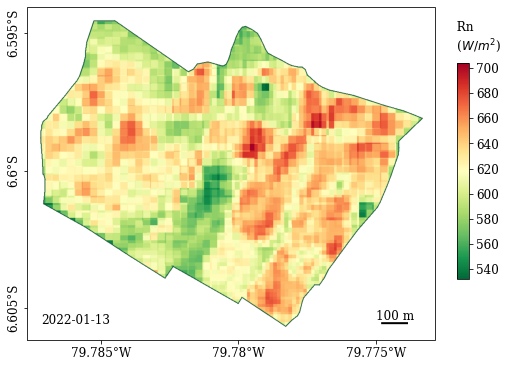

In [13]:
# Visualización cartoee
vis_params = vis_params_R_n
title_map = img_date_format2 # f'R_n\n{img_date_format1}' # dd-mm-YYYY
label = '  Rn\n  ($W/m^2$)' # '$[\; W/m^2 \;]$'
ruta = f'{img_date_format2}_Rn'

get_grafica_cartoee_color(image, vis_params, text=title_map, label=label)#, save_fig=ruta)

##### Albedo

Según Hiroguchi, Ikuo (1992), los valores típicos de albedo superficial para campos de arroz es de 0.17 - 0.22.

In [12]:
display(img_date_format2, img_prod_stats_df['albedo']) 

'2022-03-10'

max       0.210209
mean      0.157055
median    0.163518
min       0.038788
mode      0.163518
stdDev    0.030651
Name: albedo, dtype: float64

In [14]:
# Visualización
vis_params_alb = {'min': 0, #,float(img_prod_stats['min']['albedo']), 
                  'max': img_prod_stats['max']['albedo'], 
                  'palette': cmp.get_palette('cubehelix')} # RdYlGn_r, afmhot, turbo_r

image_alb = img_productos.select('albedo').clip(predios_agricolas).blend(predios_vis)
# image = image.updateMask(image.lte(0.22).And(image.gt(0.17)))

# geemap
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(imageRGB, vis_rgb, 'RGB TOA')
Map.addLayer(image_alb, vis_params_alb , 'IMG Albedo') 

Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

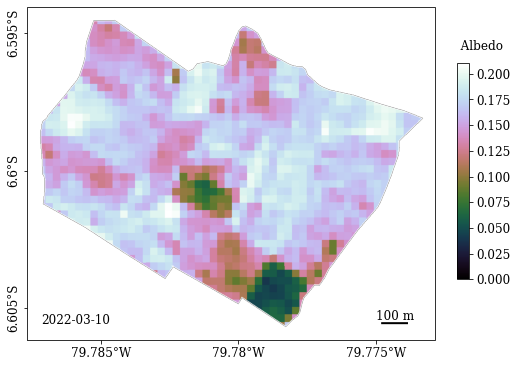

In [16]:
vis_params = vis_params_alb
title_map = img_date_format2
label = '  Albedo'# '$[\; W/m^2 \;]$'
ruta = f'{img_date_format2}_Albedo'

get_grafica_cartoee_color(image_alb, vis_params, text=title_map, label=label)#, save_fig=ruta)

##### Temperatura Superficial (Tasumi, 2003)

In [17]:
display(img_date_format2, img_prod_stats_df['Ts_c']) 

'2022-03-10'

max       29.774638
mean      25.582867
median    25.418676
min       24.818607
mode      25.326462
stdDev     0.602802
Name: Ts_c, dtype: float64

In [18]:
# Visualización
vis_params_ts = {'min': img_prod_stats['min']['Ts_c'],
                 'max': img_prod_stats['max']['Ts_c'],
                 'palette': cmp.get_palette('RdYlBu_r')}

image = img_productos.select('Ts_c').clip(predios_agricolas).blend(predios_vis)

# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(imageRGB, vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ts, 'Img Ts') 

Map.add_colorbar(vis_params_ts, label='Ts [°C]', orientation="vertical")
Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

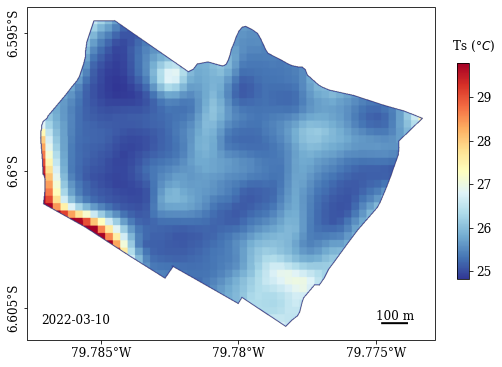

In [21]:
vis_params = vis_params_ts
title_map = img_date_format2
label = ' Ts ($°C$)'#'$[\; °C \;]$'
ruta = f'{img_date_format2}_Ts'

get_grafica_cartoee_color(image, vis_params, text=title_map, label=label)#, save_fig=ruta)

###### Comparativa entre productos TOA y SR

**Brightness Temperature - Landsat 9 T1_TOA**

In [ ]:
# Landsat 9 T1_TOA
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113')
    .clip(predios_bound)
    .select('B10')
    .subtract(273.15) # en °C
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

In [ ]:
vis_rgb_toa = {
    'min':stats['min']['B10'],
    'max':stats['max']['B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}

img = img_ee.clip(predios_agricolas).blend(predios_vis)

Map = geemap.Map()
Map.centerObject(img_ee, 16)
Map.addLayer(img, vis_rgb_toa, 'img_toa')
Map.add_colorbar(vis_rgb_toa, label='[°C]', orientation="vertical")
Map

**Surface Temperature - Landsat 9 T1_L2**

In [ ]:
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_010065_20220113')
    .clip(predios_bound)
    .select('ST_B10')
    .multiply(0.00341802).add(149.0)
    .subtract(273.15) # en °C
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

In [ ]:
vis_rgb_SR = {
    'min':stats['min']['ST_B10'],
    'max':stats['max']['ST_B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}

image = img_ee.clip(predios_agricolas).blend(predios_vis)

Map = geemap.Map()
Map.centerObject(img_ee, 16)
Map.addLayer(image, vis_rgb_SR, 'img_L9_SR')
Map.add_colorbar(vis_rgb_SR, label='[°C]', orientation="vertical")
Map

##### e_NB, e_0

**Narrow band transmissivity e_NB**: representing the surface emissivity within the band range of the satellite thermal sensor.
- Requerido para: Outgoing long-wave radiation
    
**Broad-band surface emissivity e_0** 
- Requerido para: Surface Temperature (Ts)

In [ ]:
image_ee = ee.Image('LANDSAT/LC09/C02/T1/LC09_010065_20220113') # 13-01-2022
img_toa = convert_RAW_to_TOA(image_ee).clip(predios_agricolas)

img_ndvi = get_ndvi_L8(img_toa)
ndvi_stats = get_stats(img_ndvi, predios_agricolas, 30)

img_savi = get_savi_L8(img_toa)
savi_stats = get_stats(img_savi, predios_agricolas, 30)

img_lai = get_lai_L8(img_savi)
lai_stats = get_stats(img_lai, predios_agricolas, 30)

display(ndvi_stats) # OJO: valores negativos en fecha 01_13
display(savi_stats)
display(lai_stats)

In [ ]:
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1

vis_ndvi = {'min': -0.2,
            'max': 1,
            'palette': ndvi_cmap} #cmp.palettes.afmhot

vis_lai = {'min':lai_stats['min']['LAI'],
           'max':lai_stats['max']['LAI'],
           'palette':cmp.get_palette('terrain')}

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')
Map.addLayer(img_ndvi, vis_ndvi, 'NDVI')
# Map.addLayer(img_lai, vis_lai, 'LAI')

Map

In [ ]:
# e_0 : Surface emissivity is computed using an empirical equation by Tasumi (2003) based on soil and vegetative
# thermal spectral emissivities housed in the MODIS UCSB Emissivity Library (2004)
e_0 = img_lai.expression( '0.95 + 0.01*LAI', {'LAI':img_lai}).rename('e_0') # LAI <= 3 y NDVI > 0

e_0 = e_0.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_0 = e_0.where(img_lai.gt(3), 0.98).rename('e_0') # LAI > 3; NDVI > 0

e_0_stats_dict = get_stats(e_0, predios_agricolas, 30)
e_0_stats_df = pd.DataFrame.from_dict(e_0_stats_dict, orient='index').round(3)
display(e_0_stats_df)

# e_NB
e_NB = img_lai.expression('0.97 + 0.0033*LAI', {'LAI':img_lai}).rename('e_NB') # LAI <= 3 y NDVI > 0

e_NB = e_NB.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_NB = e_NB.where(img_lai.gt(3).And(img_ndvi.gt(0)), 0.98) # LAI > 3; NDVI > 0

e_NB_stats_dict = get_stats(e_NB, predios_agricolas, 30)
e_NB_stats_df = pd.DataFrame.from_dict(e_NB_stats_dict, orient='index').round(3)
display(e_NB_stats_df)

In [ ]:
# Verificación 
img_s2_01_11 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_16 = ee.Image('COPERNICUS/S2_SR/20220116T153619_20220116T153730_T17MPN').multiply(0.0001).clip(predios_bound)
# Nota: El día 01_13 se registra valores negativos de NDVI -> 
# Pudo haber riego ya que en la imagen img_s2_01_16 se logra ver rastros 

**Broad-band surface emissivity e_0** 

In [ ]:
vis_e_0 = {'min': e_0_stats_dict['min']['e_0'],
           'max': e_0_stats_dict['max']['e_0'],
           'palette':cmp.get_palette('binary')}

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')
Map.addLayer(img_s2_01_11, vis_rgb, 'img_s2_01_11')
Map.addLayer(img_s2_01_16, vis_rgb, 'img_s2_01_16')

Map.addLayer(e_0, vis_e_0, 'e_0')
Map.add_colorbar(vis_e_0, label='[-]', orientation="vertical")
Map

**Narrow band transmissivity e_NB**

In [ ]:
e_NB_stats_df['e_NB']

In [ ]:
# Visualización
vis_params_e_nb = {'min': e_NB_stats_dict['min']['e_NB'],
                   'max': e_NB_stats_dict['max']['e_NB'],
                   'palette': cmp.get_palette('binary')}

image = img_productos.select('e_NB').clip(predios_agricolas)

vis_params = vis_params_e_nb
title_map = 'e_nb'
label = '$[\; - \;]$'

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(e_NB, vis_params_e_nb, title_map) 

Map.add_colorbar(vis_params_e_nb, label=label, orientation="vertical")

Map

##### NDVI

In [8]:
display(img_date_format2, img_prod_stats_df['NDVI'])

'2022-01-13'

max       0.642031
mean      0.173936
median    0.158279
min      -0.148500
mode      0.126808
stdDev    0.122044
Name: NDVI, dtype: float64

In [10]:
# Visualización
# ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1

vis_params_ndvi = {'min': 0, 
                   'max': 1, 
                   'palette': ndvi_cmap}

image = img_productos.select('NDVI').clip(predios_agricolas).blend(predios_vis)

# if img_prod_stats['min']['NDVI'] < 0:
#   # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
#   image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ndvi, 'Img NDVI') 

Map.add_colorbar(vis_params_ndvi, label= 'NDVI [-]', orientation= 'vertical')

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

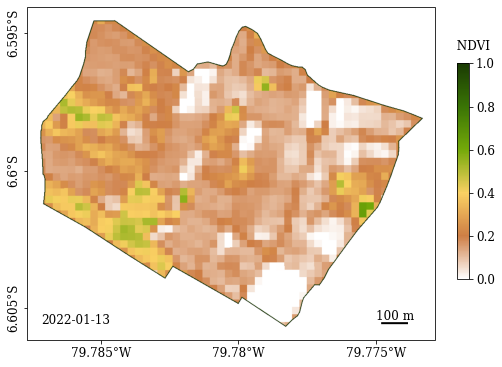

In [12]:
# Prueba: Producir imagen sin ejes 
vis_params = vis_params_ndvi
# title_map = img_date_format2 # f'NDVI\n{img_date_format2}'
title_map = img_date_format2
label = '  NDVI'#'$[\; - \;]$'
ruta = f'{img_date_format2}_NDVI_prueba'

get_grafica_cartoee_color(image, vis_params, text=title_map, label=label)#, save_fig=ruta)
# get_grafica_cartoee_color(image, vis_params)#, text=title_map, save_fig=ruta)

##### Área Foliar / LAI

Los valores típicos de albedo para arroz se encuentran en el manual SEBAL 2002.

Arroz: 0.17 - 0.22

###### **LAI a partir de NDVI con medición en campo**

La relación NDVI-LAI se ha agregado a la función ``getRadiacionNeta(img_ee, roi, dem)``

In [ ]:
# get_stats(img_ndvi, predios_agricolas, 30)

# # LAI a partir de NDVI: IAF = 2.1362*NDVI + 0.0869
# img_LAI_eq = img_ndvi.multiply(2.1362).add(0.0869).rename('LAI')

# img_LAI_stats = get_stats(img_LAI_eq, predios_agricolas, 30)
# img_LAI_stats

---

In [29]:
print(f'Fecha: {img_date_format2}')
img_prod_stats_df['LAI']

Fecha: 2022-03-10


max       1.824434
mean      1.570804
median    1.644671
min       0.210231
mode      1.714635
stdDev    0.255204
Name: LAI, dtype: float64

In [30]:
# Prueba: Forma de asignar un color a los valores negativos (Forma 1)
# lista_prueba = ['0000FF']
# for i in range(40):
#     lista_prueba.append(lista_prueba[0])
    
# lista_prueba = lista_prueba + cmp.get_palette('YlGn')

# vis_params_lai = {'min': img_prod_stats['min']['LAI'],
#                   'max': img_prod_stats['max']['LAI'], 
#                   'palette': lista_prueba} 

In [38]:
vis_params_lai = {'min': img_prod_stats['min']['LAI'],
                  'max': img_prod_stats['max']['LAI'], 
                  'palette': cmp.get_palette('YlGn')} # 'RdYlGn'

image = img_productos.select('LAI').clip(predios_agricolas)

# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

# Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_lai, 'LAI') 

Map.add_colorbar(vis_params_lai, label= 'LAI [-]', orientation= 'vertical')

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

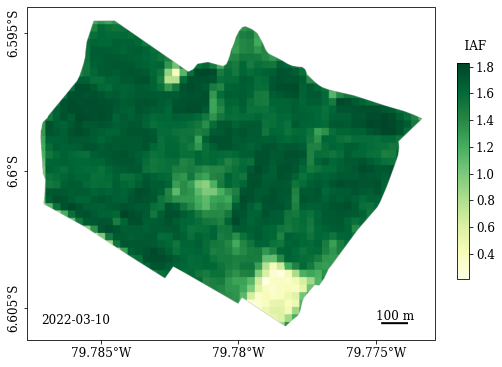

In [39]:
# Visualización
image = img_productos.select('LAI').clip(predios_agricolas)
title_map = img_date_format2 # f'LAI\n{img_date_format1}'
label = '    IAF' #'$[\; - \;]$'

get_grafica_cartoee_color(image, vis_params_lai, text=title_map, label=label)

###### LAI mediante fórmula en artículo METRIC

In [54]:
# Incorporar la siguiente expresión
# savi = image_toa.expression(
#     '(nir - red) / (nir + red + L) * (1+L)',
#     {'red' : image_toa.select('B4'),
#     'nir' : image_toa.select('B5'),
#     'L'   : ee.Number(0.5)}
#     ).rename('SAVI')
    
# lai = image_savi.expression(
#     '- (log((0.69 - savi)/0.59))/(0.91)',
#     {'savi' : image_savi.where(image_savi.gt(0.689), 0.689)} # Evitar huecos
#     ).rename('LAI')

# Índices de vegetación (eq. 23, 19 y 18)
img_ndvi = get_ndvi_L8(img_toa)
    
# Obtener LAI 1: mediante SAVI
img_savi = get_savi_L8(img_toa)
img_lai  = get_lai_L8(img_savi)

In [55]:
display(img_date_format2, img_prod_stats_df['LAI'])

'2022-06-14'

max       1.293844
mean      0.651017
median    0.683745
min       0.268857
mode      0.699269
stdDev    0.191059
Name: LAI, dtype: float64

In [70]:
# Visualización
vis_params_lai = {'min': 0, 
                  'max': 2, #img_prod_stats['max']['LAI'], 
                  'palette': cmp.get_palette('YlGn')} # cmp.get_palette('RdYlGn') 'BuGn_r' ndvi_cmap

image = img_lai.clip(predios_agricolas)#.blend(predios_vis)#.updateMask(img_lai.gt(0.5))

# Para obtener G con la equación empírica de Tasumi es necesario el mapa de LAI
# Para: 
#     LAI < 0.5 : G = 1.8*(Ts_K - 273.15) + 0.084*Rn
#     LAI >= 0.5 : G = 0.05*Rn + 0.18*exp() 

# if img_prod_stats['LAI']['min'] < 0:
  # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
  # image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

vis_params = vis_params_lai
title_map = f'LAI\n{img_date_format1}'
label = '$[\; - \;]$'

# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_lai, 'LAI') 

Map.add_colorbar(vis_params_lai, label="LAI [-]", orientation="vertical")
Map

# get_grafica_cartoee_color(image, vis_params, text=title_map, label=label)

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

###### **LAI para Idaho (Manual METRIC)**

In [ ]:
img_LAI_manual = img_savi.clip(predios_agricolas).pow(3).multiply(11).where(img_savi.gt(0.817), 6).rename('LAI')

img_LAI_manual_stats = get_stats(img_LAI_manual, predios_agricolas, 30)
img_LAI_manual_stats

In [ ]:
# Visualización
vis_params = {'min': img_LAI_manual_stats['min']['LAI'],
              'max': img_LAI_manual_stats['max']['LAI'],
              'palette': ndvi_cmap}#cmp.get_palette('YlGn')}

title_map = f'LAI\n{img_date_format1}'
label = '$[\; - \;]$'

get_grafica_cartoee_color(img_LAI_manual.blend(predios_vis), vis_params, text=title_map, label=label)

In [ ]:
# Visualización
vis_params = {'min': img_LAI_manual_stats['min']['LAI'],
              'max': img_LAI_manual_stats['max']['LAI'],
              'palette': cmp.get_palette('YlGn')}

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(img_LAI_manual, vis_params, 'LAI') 

Map.add_colorbar(vis_params, label= 'LAI [-]', orientation= 'vertical')

Map

### Flujo de calor del suelo / Soil Heat Flux $G$

#### Desarrollo

Flujo de calor del suelo $G$

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

In [17]:
# Obtener G/R_n

img_tempK = img_productos.select('Ts_k')
img_albedo = img_productos.select('albedo')
img_ndvi = img_productos.select('NDVI')

# Forma 1: Usando expression
G_Rn = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                           {'Ts_K': img_tempK,
                            'albedo': img_albedo,
                            'NDVI': img_ndvi}).rename('G_Rn').clip(predios_agricolas)

# Forma 2: Usando métodos de forma lineal (menos comprensible)
# G_R_n = (
#     img_Ts_c # Ts - 273.15
#     .multiply(img_albedo.multiply(0.0074).add(0.0038)) # albedo*0.0074 + 0.0038
#     .multiply(img_ndvi.select('NDVI').pow(4).multiply(-0.98).add(1)) 
#     .rename('G_R_n').clip(predios_agricolas)
# ) # img_Ts_c = img_Ts_k.subtract(273.15)


# Rangos de G/R_n
G_Rn_stats = get_stats(G_Rn, predios_agricolas, 30) 
# G_Rn.reduceRegion(ee.Reducer.minMax(), geometry=predios_agricolas, scale=30).values().reverse().getInfo()
# print(f'G_Rn_minmax: {G_Rn_minmax}')
display(G_Rn_stats)


# Obtener G
img_G = G_Rn.multiply(R_n.select('R_n')).rename('G')

# Rangos de G
# G_minmax = G.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo()
img_G_stats = get_stats(img_G, predios_agricolas, 30)
display(img_G_stats)
# print(f'G_minmax: {G_minmax[0]:.5f} W/m² - {G_minmax[1]:.5f} W/m²')

{'max': {'G_Rn': 0.18722339857567846},
 'mean': {'G_Rn': 0.1474775124398757},
 'median': {'G_Rn': 0.14719287753251248},
 'min': {'G_Rn': 0.11125707293159812},
 'mode': {'G_Rn': 0.14620507429943125},
 'stdDev': {'G_Rn': 0.010321129296871385}}

{'max': {'G': 75.15157505153758},
 'mean': {'G': 65.45111631150662},
 'median': {'G': 64.81063068236743},
 'min': {'G': 50.149947251237315},
 'mode': {'G': 63.30750478025207},
 'stdDev': {'G': 4.3040485281211085}}

In [ ]:
img_prod_stats_df['LAI']

In [ ]:
# # Forma 2: Tasumi (2003) using soil heat flux data collected by Wright (1982), 
# # USDA-ARS for irrigated crops near Kimberly, Idaho

# if pix_lai.getInfo() < 0.5:
#     G_pix = ee.Number.expression(
#         '1.8*(pix_ts-273.15)+0.084*R_n_calculated', # (pix_ts-273.15) cuando pix_ts es en Kelvin para obtener °C
#         {'pix_ts':pix_ts,   # pix_ts está en K
#          'R_n_calculated':R_n_calculated
#          }
#         )
# else:
#     G_pix = ee.Number.expression(
#         '0.05 + 0.18*pix_lai*R_n_calculated',
#         {'pix_lai':pix_lai.multiply(-0.521).exp(),
#          'R_n_calculated':R_n_calculated
#          }
#         )

In [ ]:
# Visualización: Flujo de calor del suelo G
vis_rgb_tasumi = {'min': 0.0,
                  'max': 0.3,
                  'bands': ['B4_SR', 'B3_SR', 'B2_SR']}

G_vis = {'min':G_minmax[0],
         'max':G_minmax[1], 
         'palette': cmp.get_palette('RdYlGn_r')}


Map = geemap.Map(layer_ctrl=True)#height='800px') 
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_sr_tasumi.clip(predios_bound), vis_rgb_tasumi, 'RGB SR') 

Map.addLayer(G, G_vis, 'G') 
# Map.addLayer(G.updateMask(G.gt(0)), {'min':0, 'max': G_minmax[1], 'palette': cmp.get_palette('RdYlGn_r')}, 'G_gt0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

### Flujo de calor sensible / Sensible Heat Flux $H$

#### Descripción

METRIC differs from previous applications of SEBAL principally in how the 'H function' is calibrated for each specific satellite image. In both METRIC and SEBAL, H (W m-2) is estimated from an aerodynamic function

$$
H = \rho_{\text{air}} C_p \frac{dT}{ r_{\text{ah}} } 
$$

Where:
- $\rho_{\text{air}}$ : air density (kg m-3)
- $C_p$ : specific heat of air at constant pressure (J kg-1 K-1)
- $r_{\text{ah}}$ : aerodynamic resistance (s m-1) between two near surface heights, z1 and z2 (generally 0.1 and 2 m) computed as a function of estimated aerodynamic roughness of the particular pixel. 

In METRIC, the $r_{\text{ah}}$ calculation **uses wind speed extrapolated from some blending height above the ground surface (typically 100 to 200 m) and an iterative stability correction scheme based on the Monin-Obhukov functions (Allen et al. 1996)**. The *dT* parameter (K) represents the near-surface temperature difference between z1 and z2. 
- *dT* is used because of the difficulty in estimating surface temperature ($T_s$) accurately from satellite due to uncertainty in atmospheric attenuation or contamination and radiometric calibration of the sensor. 

- In addition, $T_s$, as measured by satellite (i.e., radiometric or kinetic temperature) **can deviate from** the "aerodynamic" temperature that derives the heat transfer process by several degrees (Kustas et al. 1994; Norman et al. 1995; Qualls and Brutsaert 1996). 
> Además, la Ts , medida por satélite (es decir, la temperatura radiométrica o cinética) **puede desviarse de** la temperatura "aerodinámica" que deriva del proceso de transferencia de calor en varios grados (Kustas et al. 1994; Norman et al. 1995; Qualls y Brutsaert 1996).

The temperature gradient *dT* is designed to "float" above the surface, beyond the height for sensible heat roughness ($z_{oh}$) and zero plane displacement, and can be approximated as a relatively simple linear function of $T_s$ as pioneered by Bastiaanssen (1995)

$$
dT = a + b \; T_{s \; \text{datum}}
$$

where:

- $a$ and $b$ : empirically determined constants for a given satellite image  
- $T_{s \; \text{datum}}$ : surface temperature adjusted to a common elevation data for each image pixel using a digital elevation model and customized lapse rate. 

Bastiaanssen (1995) provided empirical evidence for using the linear relation between *dT* and $T_s$. Theoretically, assuming some essentially constant temperature at a blending height well above the surface, for example at 100-200 m, where temperature is nearly independent of $H$, and with all instability effects incorporated into $r_{\text{ah}}$, Eq. (28) suggests that *dT* and thus, $T_s$, will be largely proportional to H for a fixed aerodynamic condition. Therefore, one can anticipate a segment of the temperature profile, represented by *dT*, to be proportional to both $H$ and to $T_s$. 



The application of Eq. (29) appears to extend well across a range of surface roughness, because as roughness increases and $r_{ah}$ decreases, *dT*, for the same value of $H$, decreases due to a more efficient transfer of $H$, and $T_s$ reduces for the same reason. 

The determination of a and b is described in a following section. 

The use of *dT* indexed to $T_s$ that does not rely on absolute values for $T_s$ substantially reduces error in the calculation of $H$. This approach constitutes on one of the pioneering components of the SEBAL model developed by Bastiaanssen (1995). 

The use of $T_{s \; \text{datum}}$ in Eq. (29) corrects for cooling impacts on $T_s$ due to increasing evaluation within an image that are not related to *dT* and sensible heat flux.

**Aerodynamic Transport**

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

Where:
- $z_1$ and $z_2$ : heights above the zero-plane displacement of the vegetation where the endpoints of *dT* are defined 
- $u*$ : friction velocity (m s-1) 
- $k$ : von Karman's constant **(0.41)**. 

Friction velocity $u*$ is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ ku_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 



The wind speed at an assumed blending height (200 m) above the weather station, $u_{200}$, is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

Tasumi et al. (2005b) showed ET as calculated by METRIC to be relatively insensitive to the value for $z_{om}$. In METRIC, the momentum roughness length $z_{om}$ **is estimated for each pixel according to land use type or amount of vegetation**. General landuse type is used where the variation in $z_{om}$ as a function of vegetation amount is not well established. General values are given in Brutsaert (1982) and Allen et al. (1996). In agricultural areas, $z_{om}$ and, in turn, crop height is generally proportional to the LAI, and is therefore calculated as a function of LAI for “short” agricultural crops (less than about 1 m in height) using a relationship from Tasumi (2003)

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

where $z_{om}$ has units of m and LAI is dimensionless.

A minimum value for $z_{om} = 0.005$ m represents roughness typical of bare agricultural soils. Eq. (33) tends to underestimate $z_{om}$ for corn which is typically 2 to 3 m in height (Tasumi 2003), and a different function would be required for vines and trees. Because of the difficulties in estimating $z_{om}$ from a general function of LAI for all vegetation types within an image, Bastiaanssen (2000) suggested customizing a function for $z_{om}$ based on NDVI that is developed for each satellite image 

$$
z_{om} = \exp{[( a_1 \text{NDVI}) + b_1]} \qquad (34a)
$$

or, as modified by Allen (2002)

$$
z_{om} = \exp{[( a_1 \text{NDVI}/\alpha) + b_1]} \qquad (34b)
$$

where
- $a_1$ and $b_1$ : regression constants derived from a plot of $\ln{(z_{om})}$ versus NDVI or $\ln{(z_{om})}$ versus NDVI/$\alpha$ for two or more conditions in the image representing specific vegetation types. 

Eqs. (34a) and (34b) must be fitted to local vegetation and conditions. Generally $\alpha$ is lower for taller vegetation such as trees due to shading. Therefore, the use of albedo helps to distinguish between tall and short vegetation types that may have similar NDVI, but different albedo. Variations on Eqs. (34a) and (34b) can be explored by the user to improve the predictive accuracy, including use of other parameters.






**The effects of mountainous terrain and elevation on wind speed** are complicated and difficult to quantify (Oke 1987). In METRIC, $z_{om}$ for image pixels in mountains is adjusted on a rudimentary basis to attempt to account for effects of general terrain roughness on momentum and heat transfer. 

An empirical adjustment is made by multiplying $z_{om}$, as calculated using Eqs. (33) and (34a) and (34b) or from general land classification, by a function determined locally in Idaho **using slope** as computed from a digital elevation model

$$
z_{om_min} = z_{om} \left( 1 + \frac{(180/\pi)s - 5}{20} \right) \qquad (35)
$$

To further adjust the heat transfer equation for mountanious terrain, $u_{200}$ at mountainous image pixels is multiplied by a wind speed weighting coefficient ($\omega$) before computing $u*$ and $r_{ah}$. $w$ is calculated as

$$
\omega = 1+0.1 \left( \frac{\text{Elevation} - \text{Elevation}_{\text{station}}}{1000} \right) \qquad (36)
$$

where:
- $\text{Elevation}$: elevation of the pixel (m), and 
- $\text{Elevation}_{\text{station}}$: elevation where the wind speed is measured. 

Equations (35) and (36) were developed during METRIC applications in mountainous regions of southern Idaho (Tasumi 2003).


**Air density** in the aerodynamic equation is calculated using standard equations for mean atmospheric pressure and the universal gas law and simplifying for the effect of vapor pressure (virtual temperature is estimated as 1.01 $T_s$) as done by Allen et al. (1998)

$$
\rho_{air} = \frac{1000P}{1.01(T_s - dT)R}
$$

where:
- $\rho_{air}$ : air density (kg m-3)
- $P$ : mean atmospheric pressure for the pixel elevation (kPa)
- $R$ : specific gas constant (287 J kg-1 K-1)
- $T_s - dT$ : surrogate (K) for near-surface air temperature at the pixel 


#### Selección de pixeles Frío y Caliente

In [ ]:
# img_ee.get('SPACECRAFT_ID').getInfo() # 'LANDSAT_8'

Imagen Sentinel-2 que servirá de ayuda para una mejor selección de pixeles fríos y calientes.

In [17]:
vis_rgb_s2 = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'], 'gamma': 0.8} 

# img_s2_id = 'COPERNICUS/S2/20220615T153619_20220615T154006_T17MPN' # 2022-06-14
# img_s2_id = 'COPERNICUS/S2/20211212T153621_20211212T154103_T17MPN' # 2021-12-12
img_s2_id = 'COPERNICUS/S2/20220111T153621_20220111T154058_T17MPN' # 2022-01-11
img_s2 = ee.Image(img_s2_id) 
img_s2_vis = img_s2.multiply(0.0001).clip(predios_bound)
img_s2_date = img_s2.date().format('YYYY-MM-dd').getInfo()

print(img_s2_date)

2022-01-11


A continuación se realizará el friltrado de pixeles. Mediante la revisión de mapas de temperatura, NDVI y albedo es posible visualizar focos de calor.

#### Selección datos de estación

In [ ]:
# 8 Imágenes seleccionadas
# ids = [
#     'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
#       ]

fechas_imgs = []

for img_id in ids:
    img_ee = ee.Image(img_id)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    fechas_imgs.append(img_date)

# fechas_imgs = '2021-12-12',
#  '2022-01-13',
#  '2022-01-29',
#  '2022-03-10',
#  '2022-04-03',
#  '2022-05-21',
#  '2022-05-29',
#  '2022-06-14']

In [ ]:
ruta_csv = 'EE_Vista_Florida.csv'
df_estacion_vf = pd.read_csv(ruta_csv, na_values='---') 
df_estacion_vf.Date = pd.to_datetime(df_estacion_vf.Date, format='%d/%m/%Y')
# df_estacion_vf

# Cambio de formato en columna Time de object a numeric (para visualizar mejor con matplotlib)
df_prueba = df_estacion_vf.copy()
df_prueba['Time'] = pd.to_numeric(df_prueba['Time'].str.replace(":", "."))

# Extraemos los datos de la estación para las fechas de existencia de imagen satelital
datos_hora_imagen = df_prueba[df_prueba['Date'].isin(fechas_imgs)]
# datos_hora_imagen

# Visualizamos y comparamos los dataframes según la hora de filtrado
display(datos_hora_imagen[datos_hora_imagen['Time']==10.30])
display(datos_hora_imagen[datos_hora_imagen['Time']==11.00])

In [ ]:
filtrado_ws = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==10.30)]['Wind Speed']
    .values[0]
)

print(filtrado_ws) # [km/h]

filtrado_et = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==11)]['ET']
    .values[0]
)
print(filtrado_et)

#### Parte iterativa

Replicando la hoja en excel:

1. Ts_dem
1. R_n
2. G
3. Zom_flat (flat model momentum roughness length)
4. Zom (Adjusting momentum roughness length for slopes)
5. Wind coeff (Mountain wind speed adjustment coefficient)

Primer paso para la primera iteración

7. u*1 (Friction velocity, is computed using logarithmic wind law for neutral atmospheric conditions)
    - u_200 (Wind speed at a [blending height](https://glossary.ametsoc.org/wiki/Blending_height) assumed to be 200 m) 
        - u_w (Wind speed measured at a weather station at Z_x height above the surface)
        - Z_om_w (Roughness length for the weather station surface)
        - Z_x
    - Z_om
8. rah1 : Aerodynamic resistance between two near surface heights, during the first iteration, the aerodynamic resistance to heat transport is computed for neutral atmospheric stability conditions

A partir de aquí ya se necesita calcular para ambos tipos de pixeles
9. dT1 (Temperature difference T1-T2 between two heights z1 and z2)
10. p1 (Air density)
11. H1
12. L1 

Corrección

12. Ym200 1
13. Yh(z2)1
14. Yh(z1)1

**Proceso**

Procesado inicial (asumiendo condiciones atmosféricas neutrales)
1. H y dT
1. Corrección por estabilidad
1. Iteraciones
    1. Iteración (u_star, r_ah, air_dens_p y dT)
    1. H y dT
    1. Corrección por estabilidad

##### Funciones

In [11]:
def get_u_star_sp(u_200, img_Zom, correccion=None):
    
    """u_star Friction velocity
    Inputs:
    - u_200 : float
    - img_Zom : ee.Image
    - correccion (opcional): La corrección se aplica cuando se realiza la iteración con valores de 
    correción por estabilidad y200m
    Retorna:
    - u_star
    """
    
    # u*1: Friction velocity (eq 31)
    # k_const = 0.41 # von Karman's constant
    if correccion == None:
        # u_star = k_const*u_200*1/(math.log(200/Z_om)) # blending height: 200 m 
        img_ustar = img_Zom.expression('0.41*u_200/log(200/zom)',
                                        {'u_200':u_200,
                                         'zom': img_Zom}).rename('u_star')
    else: 
        y200m = correccion['y200m']
        # u_star = k_const*u_200*1/(math.log(200/Z_om) - y200m)
        img_ustar = img_Zom.expression('0.41*u_200/(log(200/zom) - y200m)',
                                        {'u_200':u_200,
                                         'zom': img_zom1,
                                         'y200m': y200m}).rename('u_star')
    
    return img_ustar

# 1. Resistencia Aerodinámica
def get_rah_sp(img_u_star, correccion=None):
    
    '''r_ah Aerodynamic resistance (eq 30) [s/m]
    Inputs:
    - u_star
    - correccion (opcional): La corrección se aplica cuando se realiza la iteración con valores de 
    correción por estabilidad yhz2 e yhz1
    Retorna:
    - r_ah 
    '''
    
    # r_ah 1 Aerodynamic resistance (eq 30) [s/m]
    k_const = 0.41
    z2 = 2
    z1 = 0.1
    operacion1 = math.log(z2/z1)
    
    if correccion == None:
        # r_ah = math.log(z2/z1)/(u_star*k_const)
        img_rah = img_u_star.expression('operacion1/(0.41*img_u_star)',
                                        {'operacion1':operacion1,
                                         'img_u_star':img_u_star}).rename('rah')
    else:
        yhz1 = correccion['yhz1']
        yhz2 = correccion['yhz2']
        # r_ah = ( math.log(z2/z1) + yhz1 - yhz2 )/(u_star*k_const)
        img_rah = img_u_star.expression('operacion1/(0.41*img_u_star)',
                                        {'operacion1':operacion1,
                                         'img_u_star':img_u_star}).rename('rah')
        # La correccion se aplica cuando se realiza la iteración con valores
        # de correccion por estabilidad yhz2, yhz1
    
    return img_rah

def get_air_dens_sp(img_dem, air_temp_K):
    
    '''air_dens_p Air density
    Inputs:
    - pix_elev
    - temp_K
    Retorna:
    - air_dens_p
    '''
    
    # (eq 37) For 20 °C: 293° = 273° + 20°
    # P estimated using a digital elevation map
    
    # air_pressure_P = 101.3*( (293.15-0.0065*pix_elev)/293.15 )**5.26  
    img_air_pressure_P = img_dem.expression('101.3*( (293.15-0.0065*dem)/293.15)**5.26',
                                      {'dem':img_dem})
    
    # air_dens_p = 1000*air_pressure_P/(1.01*(air_temp_K)*287)
    img_air_dens_p = img_air_pressure_P.expression('1000*air_pressure_P/(1.01*(air_temp_K)*287)',
                                                  {'air_pressure_P':img_air_pressure_P,
                                                   'air_temp_K':air_temp_K}).rename('air_dens_p')
                                      
    return img_air_dens_p


**Stability Correction Functions**

In order to account for the buoyancy effects generated by surface heating, METRICtm
and SEBAL apply the Monin-Obukhov theory in an iterative process.

Atmospheric conditions of stability have a large effect on the aerodynamic resistance
(rah) and must be considered in the computation of sensible heat flux (H), especially for
dry conditions.

METRICtm and SEBAL repeat the computation of H through a number of iterations, each one correcting for buoyancy effects, **until the value for rah stabilizes**. Stabilization usually occurs after four or five iterations. 

**The Monin-Obukhov length (L) is used to define the stability conditions of the atmosphere in the iterative process** (note, this is not the same “L” as used in the SAVI computation). L is the height at which forces of buoyancy (or lack of) and mechanical mixing are equal. 

Se realiza la longitud de Monin-Obukhov, luego se corrige la velocidad de fricción u*, luego se corrige la resistencia aerodinámica r_ah .

##### Primera iteración (Prueba)

Para el pixel caliente, se asume que el suelo debe estar lo suficientemente seco para producir un valor de LE igual a 0. Para obtener dicho valor, se considera un Kc igual a 0 para resultar en LE igual a 0.

- LE: latent energy consumed by ET, latent heat flux

In [ ]:
# Primera iteración
pix_c_procesado_inicial = procesado_inicial(pix_c_values, filtrado_ws, filtrado_et, Kc=1.05)
pix_h_procesado_inicial = procesado_inicial(pix_h_values, filtrado_ws, filtrado_et, Kc=0) 

u_200 = pix_c_procesado_inicial['u_200']

print('Resultados de primera iteración (asumiendo condiciones atmosféricas neutrales)')
display(pix_c_procesado_inicial)
display(pix_h_procesado_inicial)

In [ ]:
# Obtener dT y luego H
pix_c_procesado, pix_h_procesado = get_H(pix_c_procesado_inicial, pix_h_procesado_inicial)
# Agrega dT1 y H1

# Corrección por estabilidad
pix_c_stability_cor = stability_corr(pix_c_procesado)
pix_h_stability_cor = stability_corr(pix_h_procesado)

display(pix_c_procesado, pix_c_stability_cor)
display(pix_h_procesado, pix_h_stability_cor)

La variación entre densidades del agua depende del parámetro dT0 que en el pixel caliente sale con valor alto. Para la primera iteración se usó el dato de 20°C de temperatura para obtener las densidades del agua. El parámetro dT depende de H.

In [ ]:
# Segunda iteración
pix_c_iter = iteracion(u_200, pix_c_procesado, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
pix_h_iter = iteracion(u_200, pix_h_procesado, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])

# Coeficientes
pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)

display(pix_c_iter, pix_c_post_iter)
display(pix_h_iter, pix_h_post_iter)

In [ ]:
# Corrección por estabilidad
pix_c_stability_cor = stability_corr(pix_c_post_iter)
pix_h_stability_cor = stability_corr(pix_h_post_iter)

display(pix_c_post_iter, pix_c_stability_cor)
display(pix_h_post_iter, pix_h_stability_cor)

----

##### Evaluación de fecha: 2022-03-10

In [51]:
fecha = img_date_format2 # 2022-03-10
filtrado_ws = 3.2  # km/h
filtrado_et = 0.53  # mm/h

print(fecha)

# pix_c_values = pix_cold_values
# pix_h_values = pix_hot_values

# n1: 50 - n2: 10
# 10-03-2022
# Pixel Frío: [-79.784451, -6.597031]

pix_c_values = {'Albedo': 0.14747657998818953,
 'Elev_m': 47,
 'G': 50.78114735764667,
 'LAI': 1.6667277490774906,
 'NDVI': 0.7395504864139549,
 'R_n': 591.7990797337761,
 'Slope_d': 0,
 'T_sw': 0.6738504697590708,
 'Ts': 24.818606619310742,
 'e_0': 0.9666672774907749}


# n1: 50 - n2: 70
# 10-03-2022
# Pixel Caliente: [-79.777671, -6.60432]

pix_h_values = {'Albedo': 0.06610982200184219,
 'Elev_m': 45,
 'G': 76.4373511015453,
 'LAI': 0.5352382716049381,
 'NDVI': 0.20987654320987645,
 'R_n': 662.8517020631945,
 'Slope_d': 0.9336038688610028,
 'T_sw': 0.6738631666008162,
 'Ts': 26.9363186058946,
 'e_0': 0.9553523827160494}

display('pixel frío', pix_c_values) # Pixel frío seleccionado
display('pixel caliente', pix_h_values) # Pixel caliente seleccionado

2022-03-10


'pixel frío'

{'Albedo': 0.14747657998818953,
 'Elev_m': 47,
 'G': 50.78114735764667,
 'LAI': 1.6667277490774906,
 'NDVI': 0.7395504864139549,
 'R_n': 591.7990797337761,
 'Slope_d': 0,
 'T_sw': 0.6738504697590708,
 'Ts': 24.818606619310742,
 'e_0': 0.9666672774907749}

'pixel caliente'

{'Albedo': 0.06610982200184219,
 'Elev_m': 45,
 'G': 76.4373511015453,
 'LAI': 0.5352382716049381,
 'NDVI': 0.20987654320987645,
 'R_n': 662.8517020631945,
 'Slope_d': 0.9336038688610028,
 'T_sw': 0.6738631666008162,
 'Ts': 26.9363186058946,
 'e_0': 0.9553523827160494}

**Parte iterativa: Resultados**

This iterative process is repeated until the successive values for **dT_hot** and **r_ah** at the "hot" pixel have stabilized. 

Next, compute the final corrected value or the sensible heat flux (H) at each pixel, which will be used in the computation of the instantaneous ET at each pixel.

40 iteraciones realizadas!


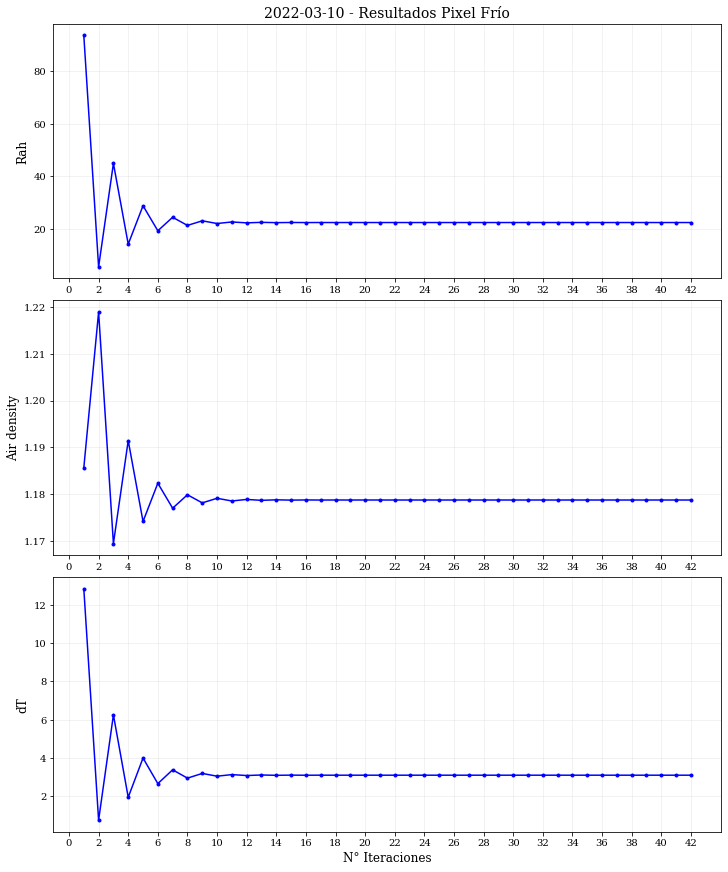

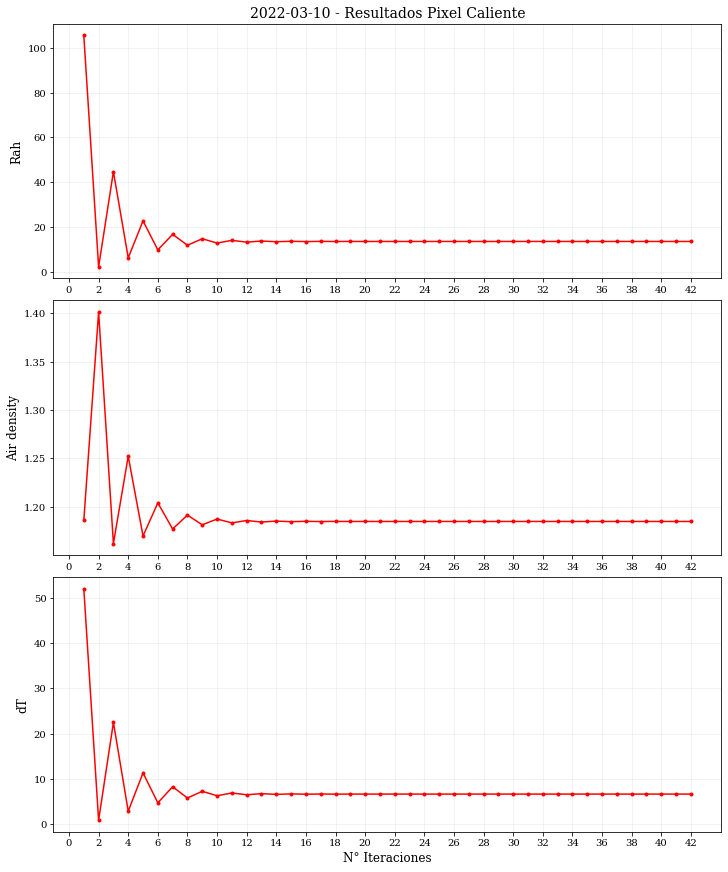

In [52]:
# Parte iterativa '2022-03-10'
n_iteraciones = 40
dict_pix_f_resultados, dict_pix_c_resultados, resultados_coef, u_200, list_stability_result = parte_iterativa(
    n_iteraciones,
    pix_c_values, pix_h_values, 
    filtrado_ws, filtrado_et)

list_variables = ['r_ah', 'air_dens_p', 'dT0']
# Plot Pixel frío
get_grafica_iteracion(fecha, dict_pix_f_resultados, 'Pixel Frío', list_variables, 'blue', n_iteraciones) 

# Plot Pixel Caliente
get_grafica_iteracion(fecha, dict_pix_c_resultados, 'Pixel Caliente', list_variables, 'red', n_iteraciones)

##### Evaluación de fecha 2022-06-14

----

###### REVISIÓN DE FUNCIÓN ITERATIVA

1. Procesado inicial
2. u_200
3. get H
4. Stability correction
5. Iteraciones

In [13]:
img_productos.bandNames().getInfo()

['NDVI',
 'LAI',
 'albedo',
 'Ts_k',
 'Ts_c',
 't_sw',
 'e_0',
 'e_NB',
 'cos_theta',
 'slope']

In [12]:
# Inputs principales
img_productos_clipped = img_productos.clip(predios_agricolas)

img_tempK = img_productos_clipped.select('Ts_k')
img_tempC = img_productos_clipped.select('Ts_c')

img_albedo = img_productos_clipped.select('albedo')
img_ndvi = img_productos_clipped.select('NDVI')
img_lai = img_productos_clipped.select('LAI')

img_slope = img_productos_clipped.select('slope')
dem = ee.Image("USGS/SRTMGL1_003")

In [13]:
##### Procesado Inicial #####
# 1. Ts_dem
img_tsdem = img_tempK.expression('img_ts + tlapse_rate/1000*(dem-Elev_station)',
                                 {'img_ts':img_tempK,
                                  'tlapse_rate':6.5,
                                  'dem': dem,
                                  'Elev_station': 3})

# 2. Momentum roughness length Z_om
# Flat model momemtum roughnes length
# img_lai < 0.2778 -> Z_om = 0.005 # represents roughness typical of bare agricultural soils
# img_lai >= 0.2778 -> Z_om = 0.018*img_lai
img_zom1 = img_lai.where(img_lai.gte(0.2778), img_lai.multiply(0.018)).where(img_lai.lt(0.2778), 0.005).rename('Z_om')

# 3. Friction velocity
h = 0.15
z_om_w = 0.12*h
blending_h = 200
u_w = filtrado_ws*1000/3600 # dato_ws en Km/hr -> m/s
z_x = 2.5  # altura del anemómetro, varía de 2 a 2.80m (relativo a cada estación)
u_200 = u_w*math.log(blending_h/z_om_w)/math.log(z_x/z_om_w) # [m/s]

# u*1: Friction velocity (eq 31)
img_u_star = get_u_star_sp(u_200, img_zom1)
# get_stats(img_u_star, predios_agricolas, 30)

img_r_ah = get_rah_sp(img_u_star)
# get_stats(img_r_ah, predios_agricolas, 30)

img_air_dens_p = get_air_dens_sp(dem, air_temp_K=20+273.15) # Para 20°
# get_stats(img_air_dens_p, predios_agricolas, 30)

img_lambdaLE = img_tempC.expression('( 2.501-0.002361*(Ts_c) )*10**6',{'Ts_c':img_tempC})
# Kc = 1.05 # Kc = 0 para pixel caliente 
# Inst_ETr * Kc * lambda_LE / 3600 # Eq 53

Inst_ETr = filtrado_et
Kc = 0
img_LE = img_lambdaLE.expression('Inst_ETr*Kc*lambda_LE/3600',
                             {'Inst_ETr': Inst_ETr, 'Kc':Kc, 'lambda_LE': img_lambdaLE})

img_Rn = R_n.select('R_n').clip(predios_agricolas).rename('0_Rn')
img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                             {'Ts_K': img_tempK,
                              'albedo': img_albedo,
                              'NDVI': img_ndvi}).multiply(R_n.select('R_n')).rename('1_G')

img_H = img_Rn.subtract(img_G).subtract(img_LE).rename('H')
img_H_stats = get_stats(img_H, predios_agricolas, 30)
img_H_stats
# H = R_n - G - LE 

{'max': {'H': 450.0235194140333},
 'mean': {'H': 379.45930923851404},
 'median': {'H': 378.54503718379897},
 'min': {'H': 290.52237357699795},
 'mode': {'H': 366.56873513222666},
 'stdDev': {'H': 27.619575652048407}}

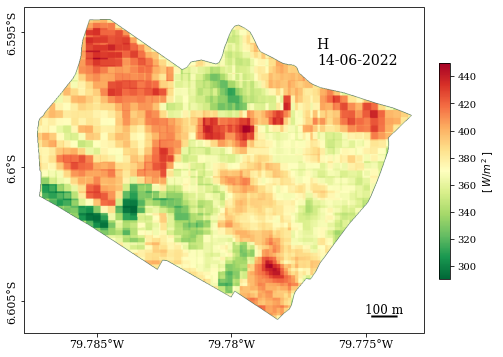

In [19]:
vis_H = {'min': img_H_stats['min']['H'],
         'max': img_H_stats['max']['H'],
         'palette': cmp.get_palette('RdYlGn_r')}

image = img_H.blend(predios_vis)
title_map = f'H \n{img_date_format1}'
label = '$[\; W/m^2 \;]$'

get_grafica_cartoee_color(image, vis_H, text=title_map, label=label)

In [15]:
pixelf = ee.Geometry.Point([-79.778717, -6.60486])
image.reduceRegion(ee.Reducer.first(), geometry=pixelf, scale=30).getInfo()

{'H': 79.14544535002517}

### $\lambda{ET}$ y $ET$ instantánea

#### Procesamiento

In [3]:
# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes seleccionadas
ids = [
#     'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

In [4]:
# Imagen Landsat
index = 2 # 0 1 Enero, 2 Marzo, 3 Junio 

img_id = ids[index] 
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas)

# Fechas 
fecha = img_ee.date().format('YYYY-MM-dd').getInfo()

# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=2) # roi: Ferreñafe

print(f'Productos y Rn de imagen {fecha} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

img_ndvi = img_productos_clipped.select('NDVI')
# img_savi = img_productos.select('SAVI')
img_lai  = img_productos_clipped.select('LAI')
img_albedo = img_productos_clipped.select('albedo')
img_tempC = img_productos_clipped.select('Ts_c')
img_tempK = img_productos_clipped.select('Ts_k')
img_slope = img_productos_clipped.select('slope')

cos_theta_rel = img_productos_clipped.select('cos_theta')
t_sw = img_productos_clipped.select('t_sw')
e_0  = img_productos_clipped.select('e_0')

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)
display(img_productos_df)

# R_n_stats = get_stats(R_n, predios_agricolas, 10)
# R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

# img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
# img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)

Productos y Rn de imagen 2022-03-10 procesada!


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,elevation,slope,t_sw
max,1.824434,0.813376,0.577836,29.774638,302.924638,0.210209,0.907059,0.968244,0.976021,54.000000,6.230337,0.673971
mean,1.570804,0.694646,0.438945,25.582867,298.732867,0.157055,0.863710,0.965708,0.975184,46.121525,1.692146,0.673854
median,1.644671,0.728591,0.462851,25.418676,298.576604,0.163518,0.862503,0.966491,0.975418,46.000000,1.860307,0.673852
min,0.210231,0.057734,0.020029,24.818607,297.968607,0.038788,0.827631,0.952102,0.970694,40.000000,0.000000,0.673761
mode,1.714635,0.759826,0.490374,25.326462,298.455588,0.163518,0.862503,0.967103,0.975540,45.000000,0.930368,0.673836
stdDev,0.255204,0.119466,0.097222,0.602802,0.602802,0.030651,0.011927,0.002552,0.000842,2.046017,0.960372,0.000031


In [39]:
# Diccionarios de visualización
vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('cubehelix') 
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}


# cmp.palettes.gist_rainbow
#cmp.get_palette('afmhot') albedo_cmap

#### Procesado

##### Corrección de H

In [18]:
# Visualización

vis_Rn = {'min': 300, # img_final_stats['min']['0_Rn'],
          'max': 700, #img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('RdYlGn_r')}

vis_G = {'min': 0,   # img_final_stats['min']['1_G'],
         'max': 100, # img_final_stats['max']['1_G'],
         'palette': cmp.get_palette('RdYlGn_r')}

vis_H = {'min': 100,   # img_final_stats['min']['2_H'],
         'max': 700, # img_final_stats['max']['2_H'],
         'palette':cmp.get_palette('RdYlBu_r')}

paleta_LE = cmp.get_palette('RdYlGn_r')
paleta_LE.insert(0, 'FFFFFF')

vis_LE = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 500, # img_final_stats['max']['3_LE'],
          'palette': paleta_LE}

vis_LE_clip = {'min': 0, #img_final_stats['min']['3_LE'],
               'max': 500, # img_final_stats['max']['3_LE'],
               'palette':cmp.get_palette('RdYlGn_r')}

# Para evaluar
# Map = geemap.Map()
# Map.centerObject(predios_agricolas, 16)
# Map.addLayer(img_rgb, vis_rgb, 'imgTOA')
# Map.addLayer(img_Rn, vis_Rn, 'img_Rn')
# Map.addLayer(img_G, vis_G, 'img_G')
# Map.addLayer(img_H, vis_H, 'img_H')
# Map.addLayer(img_LE, vis_LE, 'img_LE')
# Map.addLayer(img_LE.updateMask(img_LE.gte(0)), vis_LE_clip, 'img_LE>0')
# Map.addLayer(img_LE.updateMask(img_LE.lt(0)), {}, 'Prueba LE<0')
# Map.add_colorbar(vis_LE_clip, orientation='horizontal')
# Map

##### Prueba gráficos

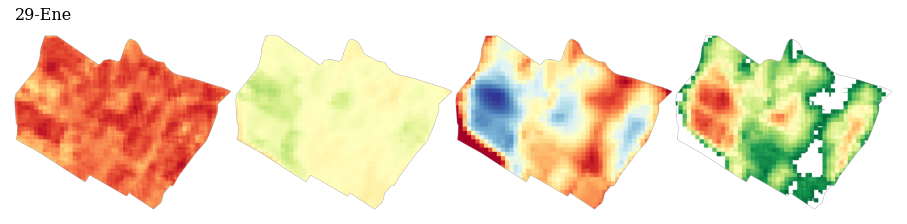

In [26]:
extent = 0.0005
zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]

fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(ncols=4, wspace=-0.05)
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

left = 0.45 # 0.875
bottom = -0.2
width = 0.02 # 0.02
height = 0.35 # 0.125
dims = 1000

escoger_fecha = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']
axs[0].text(-79.7872, -6.594549+2*extent, escoger_fecha[index], fontsize=16)

cartoee.add_layer(axs[0], img_Rn, dims=dims, region=zoom_region, vis_params=vis_Rn)
axs[0].axis('off')

cartoee.add_layer(axs[1], img_G, dims=dims, region=zoom_region, vis_params=vis_G)
axs[1].axis('off')

cartoee.add_layer(axs[2], img_H, dims=dims, region=zoom_region, vis_params=vis_H)
axs[2].axis('off')

cartoee.add_layer(axs[3], img_LE, dims=dims, region=zoom_region, vis_params=vis_LE)
axs[3].axis('off')

if index is 3:
    
    cartoee.add_colorbar(axs[0], vis_params=vis_Rn, loc='right', posOpts=[0.2, bottom, width, height], tick_font_size=14)
    axs[0].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'Rn', fontsize=14)

    cartoee.add_colorbar(axs[1], vis_params=vis_G, loc='right', posOpts=[0.38, bottom, width, height], tick_font_size=14)
    axs[1].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'G', fontsize=14)


    cartoee.add_colorbar(axs[2], vis_params=vis_H, loc='right', posOpts=[0.56, bottom, width, height], tick_font_size=14,
                        ticks=[100, 300, 500, 700])
    axs[2].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'H', fontsize=14)

    cartoee.add_colorbar(axs[3], vis_params=vis_LE, loc='right', posOpts=[0.74, bottom, width, height], tick_font_size=14,
                        ticks=[100, 200, 300, 400, 500])
    axs[3].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'LE', fontsize=14)


img_name = f'{fecha}_horz_balance_comp.jpg'
plt.savefig(ruta+img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);
plt.show()

In [ ]:
# cartoee.add_colorbar(axs[2], vis_params=vis_params_alb, 
#                      loc='right', 
#                      posOpts=[0.56, bottom, width, height], 
#                      tick_font_size=14,
#                      ticks=[0, 0.1, 0.17, 0.25])

##### Evapotranspiración

Evapotranspiración instantánea al momento de toma de imagen.

$$
ET_{inst} \text{(mm/hr)}= 3,600 \frac{LE}{\lambda} 
$$

Calor latente de vaporización $\lambda \; (J kg^{-1})$ 

$$
\lambda = [2.501 - 0.00236 \; ( T_s - 273.15)] \times 10^6
$$

In [19]:
img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET') # mm/hr
img_ET_inst = img_ET_inst.multiply(24) # mm/dia

img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)
img_ET_inst_stats_df

,ET
max,6.189763
mean,0.355959
median,1.140315
min,-29.696157
mode,2.385530
stdDev,4.066491


In [ ]:
# vis_et = {'min': 0,
#           'max': img_ET_inst_stats['max']['ET'],
#           'palette': cmp.get_palette('RdYlGn_r')}

# imgET1 = img_ET_inst.updateMask(img_ET_inst.lt(0))
# imgET2 = img_ET_inst.updateMask(img_ET_inst.gte(0))

# # Para evaluar
# Map = geemap.Map()
# Map.centerObject(predios_agricolas, 16)

# Map.addLayer(img_rgb, vis_rgb, 'imgTOA')
# Map.addLayer(img_ET_inst, vis_et, 'img_ET')
# # Map.addLayer(img_Ts_c.clip(predios_agricolas), vis_params_ts, 'img Ts C')

# Map.addLayer(imgET1, {}    , 'imgET1 < 0')
# Map.addLayer(imgET2, vis_et, 'imgET2 > 0')

# Map.add_colorbar(vis_et, orientation='horizontal', label='ET (mm/día)')
# Map

In [20]:
dfs = [img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']], img_final_stats_df, img_ET_inst_stats_df]
df_stats = pd.concat(dfs, axis=1)
display(df_stats)

# df_stats.to_csv(f'output/csv/{fecha}_resultados.csv')

,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,ET
max,29.774638,0.813376,1.824434,0.210209,691.382619,84.508916,1319.939279,174.969388,6.189763
mean,25.582867,0.694646,1.570804,0.157055,584.126280,55.007496,519.004578,10.114207,0.355959
median,25.418676,0.728591,1.644671,0.163518,579.528811,53.372950,498.144723,34.168844,1.140315
min,24.818607,0.057734,0.210231,0.038788,530.186712,42.006730,381.883072,-835.501514,-29.696157
mode,25.326462,0.759826,1.714635,0.163518,574.570110,51.623072,481.985413,69.918414,2.385530
stdDev,0.602802,0.119466,0.255204,0.030651,26.615475,7.362497,106.650385,114.670581,4.066491


In [101]:
# Con redondeo a 2 decimales
print('\nCon redondeo')
df = df_stats.round(2)
for var in df_stats.columns:
    result1 = str(df[var]['mean']) +'±'+ str(df[var]['stdDev'])
    print(result1)


Con redondeo
20.4±1.56
0.17±0.12
0.46±0.26
0.11±0.03
621.96±27.46
58.34±4.85
492.48±63.43
71.14±81.94
2.5±2.88


In [23]:
paleta_ET = cmp.get_palette('RdYlGn_r')
paleta_ET.insert(0, 'FFFFFF')

vis_ET = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 10, # img_final_stats['max']['3_LE'],
          'palette': paleta_ET}

print(fecha)

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_ET_inst, vis_ET, 'img_ET_inst')
Map.addLayer(fcol_parcelas, {}, 'fcol_parcelas')
Map

2022-03-10


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

#### Procesado total

In [4]:
# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes seleccionadas
ids = [
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113',  # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129',  # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310',  # 3 - 03/10 - l8
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    # 'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
]

# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

In [31]:
# importlib.reload(sys.modules['funciones'])
# from funciones import *

Productos y Rn de imagen 2022-03-10 procesada!

Coeficientes:
	a_coef: 1.6078423438627618
	b_coef: -37.25789695033866

Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,ET
max,29.774638,0.813376,1.824434,0.210209,691.382619,84.508916,1319.939279,174.969389,6.189763
mean,25.582867,0.694646,1.570804,0.157055,584.126280,55.007496,519.004578,10.114207,0.355959
median,25.418676,0.728591,1.644671,0.163518,579.528811,53.372950,498.144723,34.168844,1.140315
min,24.818607,0.057734,0.210231,0.038788,530.186712,42.006730,381.883072,-835.501513,-29.696157
mode,25.326462,0.759826,1.714635,0.163518,574.570110,51.623072,481.985413,69.918414,2.385530
stdDev,0.602802,0.119466,0.255204,0.030651,26.615475,7.362497,106.650385,114.670581,4.066491


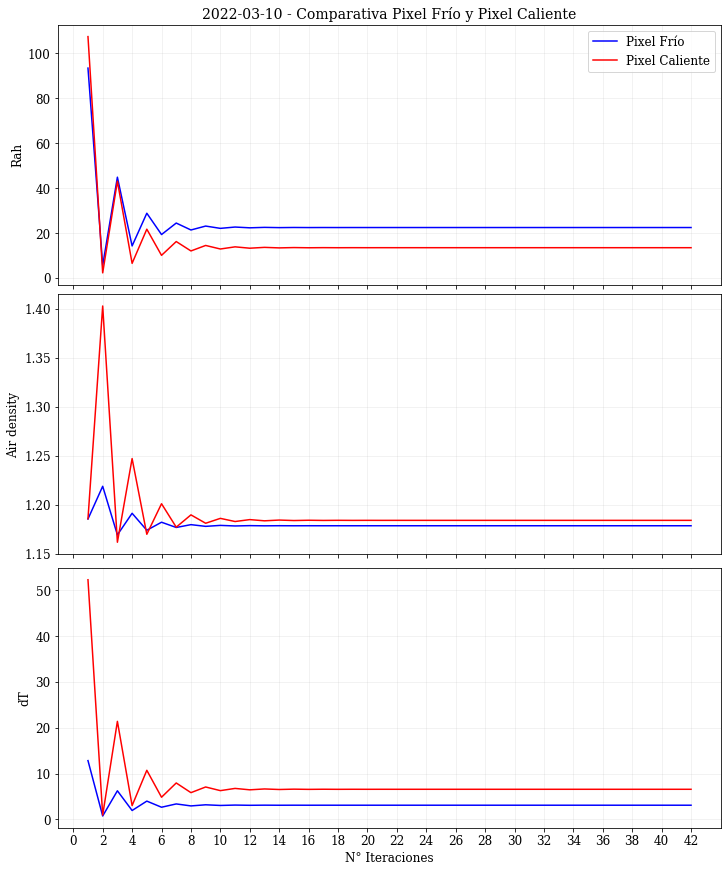

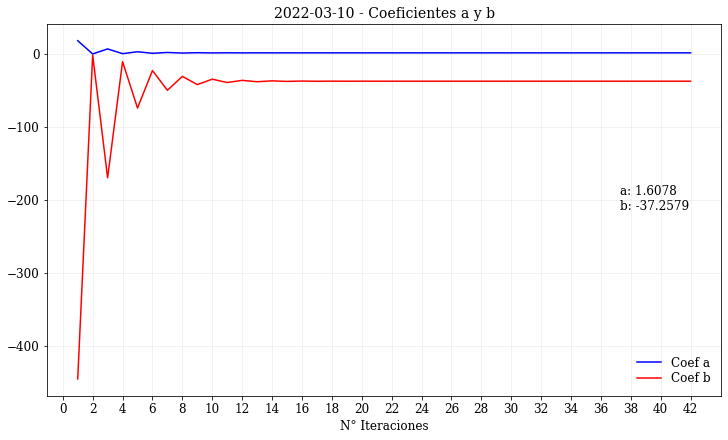

In [9]:
# =============================================================
# Inputs iniciales
# =============================================================

index = 2 # Imagen Landsat: 0 1 Enero, 2 Marzo, 3 Junio 
lai_method = 2

save_files = False
plot_balance_comp = False
ruta = f'output/{fecha}'

# =============================================================
# Radiación Neta Rn
# =============================================================

imgID = ids[index] 
imgEE = ee.Image(img_id).clip(roi)
imgTOA = convert_RAW_to_TOA(imgEE)
imgRGB = img_toa.clip(predios_agricolas)

# Fechas 
img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()
fecha = img_date_format2


# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=lai_method) # roi: Ferreñafe

print(f'Productos y Rn de imagen {img_date_format2} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

# =============================================================
# Valores de pixel frío y caliente
# =============================================================

list_weather_st = [
    [1.6, 0.3],
    [1.6, 0.69],
    [3.2, 0.53],
    [1.6, 0.46]
] # km/h

filtrado_ws, filtrado_et = list_weather_st[index]

list_coords_pixf = [
    [-79.78527, -6.598056], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.78472, -6.598345], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984], # 2 '2022-03-10' n1: 50 n2: 5
    [-79.778737, -6.604828] # 3 '2022-06-14' n1: 50 n2: 5
]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 50 n2: 70
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 3 n2: 80 
    [-79.784729, -6.595629]  # 3 '2022-06-14' n1: 10 n2: 80 
]

pixc_coord = list_coords_pixc[index]
pixc_ee_coord = ee.Geometry.Point(pixc_coord)

pix_h_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

# =============================================================
# Flujo de calor sensible H - Proceso Iterativo
# =============================================================

n_iteraciones = 40

iteracion_output = parte_iterativa(n_iteraciones, pix_c_values, pix_h_values, filtrado_ws, filtrado_et)

# Resultados del proceso iterativo
dict_pix_f_resultados = iteracion_output['dict_pix_f_resultados']
dict_pix_c_resultados = iteracion_output['dict_pix_c_resultados']
resultados_coef = iteracion_output['list_coef_resultados']
u_200 = iteracion_output['u_200']
list_stability_result = iteracion_output['list_stability_resultados']

# Coeficientes a y b
coefs_a = resultados_coef[0] 
coefs_b = resultados_coef[1]
print('\nCoeficientes:')
print(f'\ta_coef: {coefs_a[-1]}')
print(f'\tb_coef: {coefs_b[-1]}')

# ==============================================================
# - Gráfico 1: Pixel frío y caliente durante el proceso iterativo

# Plot Pixel Frío
# get_grafica_iteracion(fecha, dict_pix_f_resultados, 'Pixel Frío', 'blue', n_iteraciones, save_fig=save_files)
# plt.close()

# Plot Pixel Caliente
# get_grafica_iteracion(fecha, dict_pix_c_resultados, 'Pixel Caliente', 'red', n_iteraciones, save_fig=save_files)
# plt.close()

# ==============================================================
# - Gráfico 2: Gráfico 1 combinado

x_values = np.arange(1, n_iteraciones+2+1)

# Desarrollo de gráfica
fig, axs = plt.subplots(3,1, figsize=(10,12), layout='constrained', sharex=True)

title_name = f'{fecha} - Comparativa Pixel Frío y Pixel Caliente'
axs[0].set_title(title_name, fontsize='14')
ylabels = ['Rah', 'Air density', 'dT']

list_variables = ['r_ah', 'air_dens_p', 'dT0']

for n in range(0, 2+1):
    
    variable = list_variables[n]
    axs[n].plot(x_values, dict_pix_f_resultados[variable], 'b-', label='Pixel Frío')#, color='blue')
    axs[n].plot(x_values, dict_pix_c_resultados[variable], 'r-', label='Pixel Caliente')#, color='red')
    
    axs[n].set(xticks=np.arange(0, n_iteraciones+3, step=2), ylabel=ylabels[n])
    axs[n].grid(alpha=0.2)

axs[0].legend(fontsize='12')
axs[2].set_xlabel('N° Iteraciones');

# Guardar
if save_files is True:
    nombre_img = f'{fecha}-Comparativa Pixeles.jpg'
    fig.savefig(ruta+nombre_img) #,dpi=400);

# ==================================================================
# - Gráfico 3: Coeficientes de selección de pixeles frío y caliente

fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.plot(x_values, coefs_a, label='Coef a', color='blue')
ax.plot(x_values, coefs_b, label='Coef b', color='red')

title_name = f'{fecha} - Coeficientes a y b' 
ax.set(title=title_name, xlabel='N° Iteraciones', xticks=np.arange(0, n_iteraciones+2+1, step=2))

texto = f'a: {round(coefs_a[-1], 4)}\nb: {round(coefs_b[-1], 4)}'
ax.text(0.85, 0.5, s=texto, transform=ax.transAxes, fontsize=12)

ax.legend(fontsize=12, frameon=False, labelspacing=0.2, loc='best')
ax.grid(alpha=0.2)

# Guardar
if save_files is True:
    nombre_img = f'{title_name}.jpg'
    plt.savefig(ruta+nombre_img) #, dpi=400);

# =============================================================
# Balance de energía: LE = Rn - G - H
# =============================================================

# Corrección de H
img_H = get_H_corregido(img_productos_clipped, iteracion_output)
img_H_stats = get_stats(img_H, predios_agricolas, 30)

# Componentes de balance de energía
img_Rn = R_n.select('R_n').clip(predios_agricolas)

img_tempK = img_productos_clipped.select('Ts_k')
img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                             {'Ts_K': img_tempK,
                              'albedo': img_productos_clipped.select('albedo'),
                              'NDVI': img_productos_clipped.select('NDVI')}).multiply(R_n.select('R_n'))

# Balance de Energía
img_LE = img_Rn.expression('Rn - G - H',
                           {'Rn': img_Rn,
                            'G': img_G,
                            'H': img_H})

# Unir los componentes en una sola imagen
img_final = ee.Image([img_Rn, img_G, img_H, img_LE]).rename(['0_Rn', '1_G', '2_H', '3_LE'])
img_final_stats = get_stats(img_final, predios_agricolas, 30)
img_final_stats_df = pd.DataFrame.from_dict(img_final_stats, orient='index', dtype='float') # .round(3)

# =============================================================
# Evapotranspiración del cultivo ETinst (mm/hr y mm/d)
# =============================================================

# ET (mm/hr)
img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET')

# ET (mm/día)
img_ET_inst = img_ET_inst.multiply(24) # mm/dia

# Estadísticas
img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)

# =============================================================
# Resultados del procesamiento
# =============================================================

dfs = [img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']], img_final_stats_df, img_ET_inst_stats_df]
df_stats = pd.concat(dfs, axis=1)

print('\nResultados:')
display(df_stats)

if save_files is True:
    df_stats.to_csv(ruta + f'{fecha}_resultados.csv')

In [ ]:
# paleta_ET = cmp.get_palette('RdYlGn_r')
# paleta_ET.insert(0, 'FFFFFF')

# vis_ET = {'min': 0, # img_final_stats['min']['3_LE'],
#           'max': img_ET_inst_stats['max']['ET'],
#           'palette': paleta_ET}

# # img_name = f'{fecha}_ETinst_{lai_method}'
# # get_grafica_cartoee_color(img_ET_inst, vis_ET, fecha, label='ETinst', save_fig=img_name)

# # Map = geemap.Map()
# # Map.centerObject(predios_agricolas, 16)
# # Map.addLayer(img_ET_inst, vis_ET, 'img_ET_inst')
# # # Map.add_colorbar(vis_ET, orientation='vertical', label='ET')
# # Map

#### Evaluación de resultados

In [18]:
# Inputs iniciales

save_files = False
plot_balance_comp = False
index = 2 # Imagen Landsat: 0 1 Enero, 2 Marzo, 3 Junio 
lai_method = 2

# --------------------------------------------------------------------

img_id = ids[index] 
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas)

# Fechas 
img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()
fecha = img_date_format2


# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=lai_method) # roi: Ferreñafe

print(f'Productos y Rn de imagen {img_date_format2} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

img_albedo = img_productos_clipped.select('albedo')

Productos y Rn de imagen 2022-03-10 procesada!


In [19]:
# Descarga de archivos .tif
variables = ['NDVI', 'LAI', 'Ts_c', 'albedo']

for variable in variables:
    image = img_productos_clipped.select(variable)
    geemap.ee_export_image(
        image,
        filename=f'output/tif2/{fecha}_{variable}.tif',
        region=predios_agricolas.geometry(),
        scale=30,
        file_per_band=False
    )

Generating URL ...
Please wait ...
Data downloaded to C:\Users\usuario\Documents\00-notebooks-2022\output\tif2\2022-03-10_NDVI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\usuario\Documents\00-notebooks-2022\output\tif2\2022-03-10_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\usuario\Documents\00-notebooks-2022\output\tif2\2022-03-10_Ts_c.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\usuario\Documents\00-notebooks-2022\output\tif2\2022-03-10_albedo.tif


---

In [10]:
# Visualización de mapas
variable = 'albedo'
image = img_productos.select(variable).clip(predios_agricolas)

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(image, {}, variable)
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
vis_rgb_s2 = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'], 'gamma': 0.5} 

# img_s2_id = 'COPERNICUS/S2/20220615T153619_20220615T154006_T17MPN' # 2022-06-14
# img_s2_id = 'COPERNICUS/S2/20211212T153621_20211212T154103_T17MPN' # 2021-12-12
# img_s2_id = 'COPERNICUS/S2/20220111T153621_20220111T154058_T17MPN' # 2022-01-11
img_ee_s2 = ee.Image('COPERNICUS/S2/20220312T153621_20220312T153627_T17MPN').multiply(0.0001).clip(predios_bound)

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img toa')
Map.addLayer(img_ee_s2, vis_rgb_s2, 'img sr s2')
Map.addLayer(img_ET_inst.blend(predios_vis), vis_ET, 'img_ET_inst')
Map.add_colorbar(vis_ET, orientation='vertical', label='ET')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
vis_ET = {'min': 0, #img_ET_inst_stats['min']['ET'],
          'max': img_ET_inst_stats['max']['ET'],
          'palette': cmp.get_palette('RdYlGn')}

img = img_ET_inst.updateMask(img_ET_inst.gte(0))

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img toa')
Map.addLayer(img.blend(predios_vis), vis_ET, 'img_ET_inst')
Map.add_colorbar(vis_ET, orientation='vertical', label='ET')
Map

# img_name = f'{fecha}_ETinst_{lai_method}'
# get_grafica_cartoee_color(img_ET_inst.lt(0).updateMask(img_ET_inst), vis_ET, fecha, label='ETinst')#, save_fig=img_name)

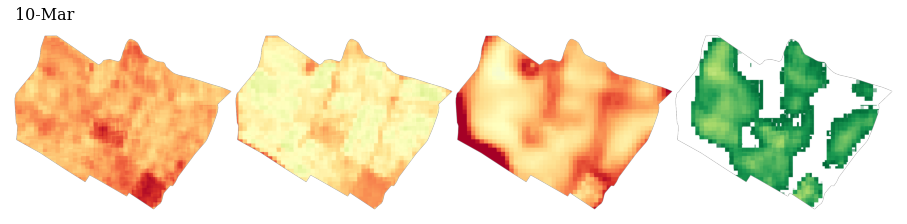

In [11]:
plot_balance_comp = True
save_files = False

# ==============================================================
# Gráfico 4: Componentes de balance de radiación

# Visualización

vis_Rn = {'min': 300, # img_final_stats['min']['0_Rn'],
          'max': 700, #img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('RdYlGn_r')}

vis_G = {'min': 0,   # img_final_stats['min']['1_G'],
         'max': 100, # img_final_stats['max']['1_G'],
         'palette': cmp.get_palette('RdYlGn_r')}

vis_H = {'min': 100,   # img_final_stats['min']['2_H'],
         'max': 700, # img_final_stats['max']['2_H'],
         'palette':cmp.get_palette('RdYlBu_r')}

paleta_LE = cmp.get_palette('RdYlGn_r')
paleta_LE.insert(0, 'FFFFFF')

vis_LE = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 500, # img_final_stats['max']['3_LE'],
          'palette': paleta_LE}

vis_LE_clip = {'min': 0, #img_final_stats['min']['3_LE'],
               'max': 500, # img_final_stats['max']['3_LE'],
               'palette':cmp.get_palette('RdYlGn_r')}

if plot_balance_comp is True:
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.35 # 0.125
    dims = 1000

    escoger_fecha = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']
    axs[0].text(-79.7872, -6.594549+2*extent, escoger_fecha[index], fontsize=16)

    cartoee.add_layer(axs[0], img_Rn, dims=dims, region=zoom_region, vis_params=vis_Rn)
    axs[0].axis('off')

    cartoee.add_layer(axs[1], img_G, dims=dims, region=zoom_region, vis_params=vis_G)
    axs[1].axis('off')

    cartoee.add_layer(axs[2], img_H, dims=dims, region=zoom_region, vis_params=vis_H)
    axs[2].axis('off')

    cartoee.add_layer(axs[3], img_LE, dims=dims, region=zoom_region, vis_params=vis_LE)
    axs[3].axis('off')

    if index is 3:
        
        cartoee.add_colorbar(axs[0], vis_params=vis_Rn, loc='right', posOpts=[0.2, bottom, width, height], tick_font_size=14)
        axs[0].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'Rn', fontsize=14)

        cartoee.add_colorbar(axs[1], vis_params=vis_G, loc='right', posOpts=[0.38, bottom, width, height], tick_font_size=14)
        axs[1].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'G', fontsize=14)


        cartoee.add_colorbar(axs[2], vis_params=vis_H, loc='right', posOpts=[0.56, bottom, width, height], tick_font_size=14,
                            ticks=[100, 300, 500, 700])
        axs[2].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'H', fontsize=14)

        cartoee.add_colorbar(axs[3], vis_params=vis_LE, loc='right', posOpts=[0.74, bottom, width, height], tick_font_size=14,
                            ticks=[100, 200, 300, 400, 500])
        axs[3].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'LE', fontsize=14)

    plt.show()
    
    if save_files is True:
        img_name = f'{fecha}_horz_balance_comp.jpg'
        plt.savefig(ruta+img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);

In [40]:
# imgs_ET = []

In [55]:
# imgs_ET.append(img_ET_inst)

In [56]:
# imgs_ET

----

Plot de imágenes de Evapotranspiración

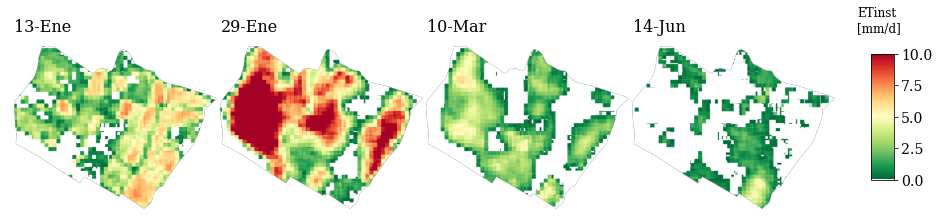

In [74]:
# Requisito: Tener las 4 imagenes de ET guardadas en una lista
fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(ncols=4, wspace=-0.05)
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

left = 0.45 # 0.875
bottom = -0.2
width = 0.02 # 0.02
height = 0.35 # 0.125
dims = 1000

escoger_fecha = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']

for i in range(4):
    axs[i].text(-79.7872, -6.594549+2*extent, escoger_fecha[i], fontsize=16)
    cartoee.add_layer(axs[i], imgs_ET[i], dims=dims, region=zoom_region, vis_params=vis_ET)
    axs[i].axis('off')

cartoee.add_colorbar(axs[3], vis_params=vis_ET, loc='right', posOpts=[0.875, 0.35, 0.02, 0.35],
                     tick_font_size=14) # posOpts=[left, bottom, width, height]
axs[3].text(-79.77332525015065+3*extent, -6.594549+2*extent, 'ETinst\n[mm/d]', fontsize=12)
    
img_name = 'output/ET_inst_horz.jpg'
plt.savefig(img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);
plt.show()

### Evapotranspiración de cultivo $ET_c$ por día

**Fracción de evapotranspiración de referencia $ET_rF$**

$ET_rF$ is the same as the well-known crop coefficient, $K_c$. When used with an alfalfa reference basis, and is used to extrapolate ET from the image time to periods of 24 h or longer.

$$
ET_rF = \frac{ET_{inst}}{ET_r}
$$

In the METRIC process, $ET_{24}$ is estimated by assuming that the instantaneous $ET_rF$ computed at image time is the same as the average $ET_rF$ over the 24 h average. 

## Pruebas

### Elaboración de gráficas: Boxplot

#### Import de variedades

In [8]:
# Imports
path_parcelas = r'input/Parcelas_wgs84_clip.shp'
fcol_parcelas = geemap.shp_to_ee(path_parcelas)

In [12]:
# Variedades
fcol_parcelas_var1 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'CAPOTEÑA')
fcol_parcelas_var2 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'GALAN')
fcol_parcelas_var3 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PAKAMURO')
fcol_parcelas_var4 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PUNTILLA')
fcol_parcelas_var5 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'VALOR')

fcol_parcelas_met1 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'TRANSPLANTE')
fcol_parcelas_met2 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'SIEMBRA DIRECTA')

variedades_list = ['Capoteña', 'Galan', 'Pakamuro', 'Puntilla', 'Valor']
list_met_names = ['Transplante', 'Siembra Directa']

#### Procesado para boxplot

In [6]:
# Por cada fecha procesada, correr celdas
img_ET_pos = img_ET_inst.updateMask(img_ET_inst.gte(0))#.blend(predios_vis)
# img_ET_neg = img_ET_inst.updateMask(img_ET_inst.lt(0))#.blend(predios_vis)

In [16]:
list_et_val1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var1, 30).get('ET').getInfo()
list_et_val2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var2, 30).get('ET').getInfo()
list_et_val3 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var3, 30).get('ET').getInfo()
list_et_val4 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var4, 30).get('ET').getInfo()
list_et_val5 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var5, 30).get('ET').getInfo()

list_values = [list_et_val1, list_et_val2, list_et_val3, list_et_val4, list_et_val5]

list_et_met1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met1, 30).get('ET').getInfo()
list_et_met2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met2, 30).get('ET').getInfo()

list_met = [list_et_met1, list_et_met2]

#### Boxplot con matplotlib

- [Matplotlib - boxplots](https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html#boxplots)

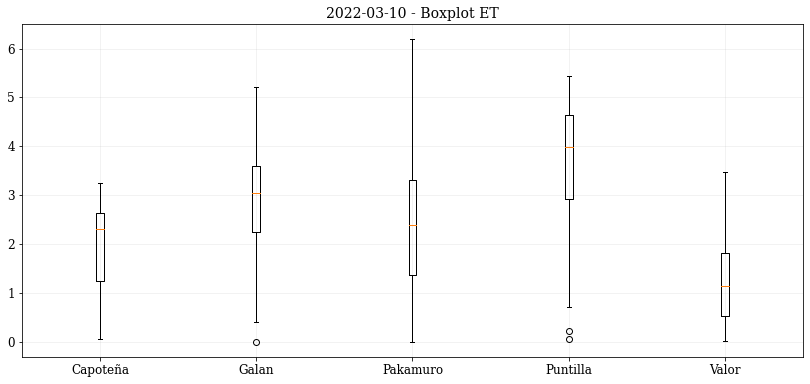

In [8]:
# Visualización de Boxplot con Matplotlib

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharey=True)

ax.boxplot(list_values, widths=0.05) # , showfliers=False
    
ax.set_title(f'{fecha} - Boxplot ET')
ax.set_xticklabels(np.repeat(variedades_list, 1))
ax.grid(alpha=.2)
# axs[0].axhline(0, color='k', ls='--', lw=1)
# axs[1].axhline(0, color='k', ls='--', lw=1)

# axs[0].set_ylim(bottom=-1)
# axs[1].set_ylim(top=1)

fig.subplots_adjust(wspace=0.05)

# plt.savefig(f'output/{fecha}_boxplot.jpg')
plt.show()

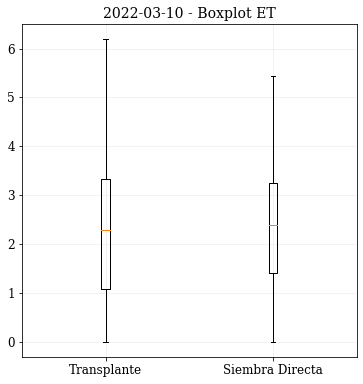

In [9]:
# Visualización de Boxplot con Matplotlib

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)

ax.boxplot(list_met, widths=0.05) # , showfliers=False
    
ax.set_title(f'{fecha} - Boxplot ET')
ax.set_xticklabels(np.repeat(list_met_names, 1))
ax.grid(alpha=.2)
# axs[0].axhline(0, color='k', ls='--', lw=1)
# axs[1].axhline(0, color='k', ls='--', lw=1)

# axs[0].set_ylim(bottom=-1)
# axs[1].set_ylim(top=1)

fig.subplots_adjust(wspace=0.05)

# plt.savefig(f'output/{fecha}_boxplot.jpg')
plt.show()

#### Boxplot con seaborn

- [Seaborn - boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

In [4]:
import seaborn as sns

def prepare_df_vertical(lista_escogida, lista_title, column_name):
    df = pd.DataFrame(list(zip(lista_escogida)), columns=['Valores'])
    df[column_name] = lista_title
    return df

In [17]:
# fecha proviene de correr la celda de radiación neta
df_var = pd.concat([ 
    prepare_df_vertical(list_values[i], variedades_list[i], 'Variedad') for i in range(5)]).reset_index(drop=True)
df_met = pd.concat([ 
    prepare_df_vertical(list_met[i], list_met_names[i], 'Metodo') for i in range(2)]).reset_index(drop=True)

df_var['Fecha'] = fecha
df_met['Fecha'] = fecha

df_var.to_csv(f'output/{fecha}_df_var_boxplot.csv', encoding='UTF-8', index=False)
df_met.to_csv(f'output/{fecha}_df_met_boxplot.csv', encoding='UTF-8', index=False)

In [5]:
list_dates = ['2022-01-13', '2022-01-29', '2022-03-10', '2022-06-14']

df_var = pd.concat([
    pd.read_csv(f'output/{fecha}_df_var_boxplot.csv') for fecha in list_dates
])
    
df_met = pd.concat([
    pd.read_csv(f'output/{fecha}_df_met_boxplot.csv') for fecha in list_dates
])

In [6]:
df_met_mod = df_met.copy()
df_met_mod['Fecha'] = 'Total'
df_met_mod

,Valores,Metodo,Fecha
0,1.311557,Transplante,Total
1,1.070096,Transplante,Total
2,1.706649,Transplante,Total
3,1.057413,Transplante,Total
4,0.677171,Transplante,Total
...,...,...,...
455,3.775905,Siembra Directa,Total
456,2.517774,Siembra Directa,Total
457,1.191346,Siembra Directa,Total
458,3.092585,Siembra Directa,Total


In [7]:
df_var_mod = df_var.copy()
df_var_mod['Fecha'] = 'Total'
df_var_mod

,Valores,Variedad,Fecha
0,1.546960,Capoteña,Total
1,0.907040,Capoteña,Total
2,1.851302,Capoteña,Total
3,0.640290,Capoteña,Total
4,1.377977,Capoteña,Total
...,...,...,...
455,1.662889,Valor,Total
456,1.265896,Valor,Total
457,1.534039,Valor,Total
458,1.696364,Valor,Total


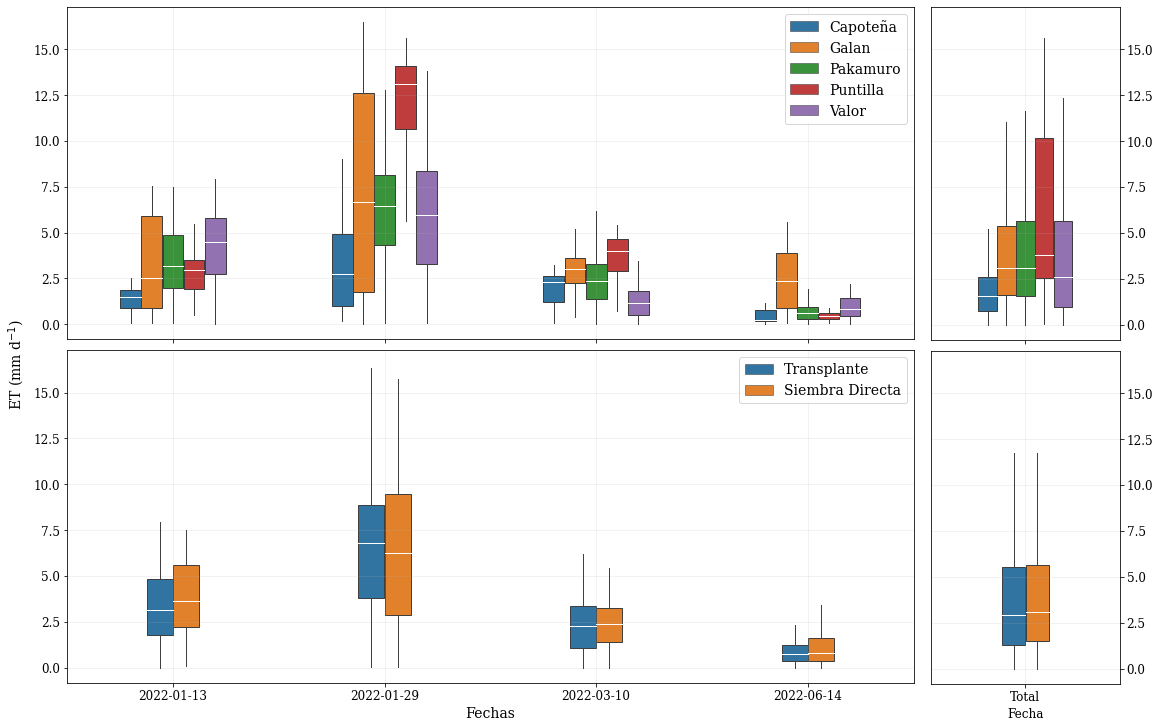

In [8]:
fontsize_legend = 14

# Diagrama de cajas con todas las fechas procesadas
fig = plt.figure(layout="constrained", figsize=(16,10))
subfigs = fig.subfigures(1, 2, width_ratios=[4, 1.])

# fig.suptitle('Diagrama de cajas - Evapotranspiración', fontsize=14)

# Sección izquierda ====================================
axs0 = subfigs[0].subplots(2, 1, sharex=True)
subfigs[0].supylabel('ET (mm d$^{-1}$)', fontsize=14)
sns.boxplot(x="Fecha", y="Valores", hue='Variedad', data=df_var, 
            ax=axs0[0],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.5,
            medianprops={'color':'white'})
axs0[0].legend(fontsize=fontsize_legend)
axs0[0].set_xlabel('')
axs0[0].set_ylabel('')
axs0[0].grid(alpha=.2)

sns.boxplot(x="Fecha", y="Valores", hue='Metodo', data=df_met, 
            ax=axs0[1],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.25,
            medianprops={'color':'white'})
axs0[1].legend(fontsize=fontsize_legend)
axs0[1].set_ylabel('')
axs0[1].set_xlabel('Fechas', fontsize=14)
axs0[1].grid(alpha=.2)


# Sección derecha ====================================
axs1 = subfigs[1].subplots(2, 1, sharex=True)
sns.boxplot(x="Fecha", y="Valores", hue='Variedad', data=df_var_mod,
            ax=axs1[0],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.5,
            medianprops={'color':'white'})
axs1[0].yaxis.set_ticks_position("right")
axs1[0].get_legend().remove()
axs1[0].set_ylabel('')
axs1[0].set_xlabel('')
axs1[0].grid(alpha=.2)

sns.boxplot(x="Fecha", y="Valores", hue='Metodo', data=df_met_mod,
            ax=axs1[1],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.25,
            medianprops={'color':'white'})
axs1[1].yaxis.set_ticks_position("right")
axs1[1].get_legend().remove()
axs1[1].set_ylabel('')
axs1[1].grid(alpha=.2)

# axs1[1].set_xlabel('')
# axs1[1].set_xticks([])

# plt.savefig('output/prueba_subfigures.jpg')

#### Prueba: Datos de arroz por propietarios

Propietario 1: DIAZ LOPEZ, MARIA DINA
Variedad Pakamuro

Propietario 2: PANTA MORALES, JORGE NORBEL
Variedad Puntilla (procesado anteriormente como fcol_parcelas_var4)

Propietario 3: CABRERA HERRERA, JUAN WENCESLAO
Variedad: Galan

Propietario 4: DOIG ORBEGOZO, VICTOR FERMIN
Variedad: Valor

Propietario 5: RAMOS MANAYAY, SANTOS PABLO
Variedad Capoteña

In [7]:
for i in range(1, 5+1):
    path_prop = f'input/propietario{i}.shp'
    prop_ee = geemap.shp_to_ee(path_prop)
    img_stats = get_stats(img_ET_pos, prop_ee, 30)
    print(f'Propietario {i}:')
    display(img_stats)

Propietario 1:


{'max': {'ET': 5.304093168717747},
 'mean': {'ET': 2.9548394254523282},
 'median': {'ET': 3.293731356853754},
 'min': {'ET': 0.17007213667245166},
 'mode': {'ET': 0.17007213667245166},
 'stdDev': {'ET': 1.385982677854053}}

Propietario 2:


{'max': {'ET': 5.444261784627659},
 'mean': {'ET': 3.5643017267644037},
 'median': {'ET': 3.982705500222246},
 'min': {'ET': 0.05398668162494672},
 'mode': {'ET': 0.05398668162494672},
 'stdDev': {'ET': 1.409322839163159}}

Propietario 3:


{'max': {'ET': 4.526794202092597},
 'mean': {'ET': 3.6051672942027877},
 'median': {'ET': 3.596301989848473},
 'min': {'ET': 2.425007406499793},
 'mode': {'ET': 2.425007406499793},
 'stdDev': {'ET': 0.5103613919848049}}

Propietario 4:


{'max': {'ET': 3.2451603141943726},
 'mean': {'ET': 1.481622952494614},
 'median': {'ET': 1.2906687353585264},
 'min': {'ET': 0.22642749429758835},
 'mode': {'ET': 0.22642749429758835},
 'stdDev': {'ET': 0.8482796968501808}}

Propietario 5:


{'max': {'ET': 3.2502169783077894},
 'mean': {'ET': 1.9810745530222114},
 'median': {'ET': 2.298383737879454},
 'min': {'ET': 0.0471245194898819},
 'mode': {'ET': 0.0471245194898819},
 'stdDev': {'ET': 0.8729075095045972}}

In [4]:
# Imports
import glob
list_propietarios = glob.glob(os.path.join('input','*.shp'))
list_propietarios
# fcol_parcelas = geemap.shp_to_ee(path_parcelas)

['input\\capoteña.shp',
 'input\\Ferreñafe_areas_2.shp',
 'input\\Ferreñafe_areas_3.shp',
 'input\\galan.shp',
 'input\\pakamuro.shp',
 'input\\Parcelas_wgs84.shp',
 'input\\Parcelas_wgs84_clip.shp',
 'input\\propietario1.shp',
 'input\\propietario2.shp',
 'input\\propietario3.shp',
 'input\\propietario4.shp',
 'input\\propietario5.shp',
 'input\\puntilla.shp',
 'input\\valor.shp']

#### Prueba Anterior

In [11]:
vis_ET_pos = {'min': 0, #img_ET_inst_stats['min']['ET'],
          'max': img_ET_inst_stats['max']['ET'],
          'palette': cmp.get_palette('RdYlGn_r')}

paleta_LE = cmp.get_palette('RdYlGn_r')
paleta_LE.insert(0, 'FFFFFF')

vis_ET_neg = {'min': img_ET_inst_stats['min']['ET'],
            'max': 0, #img_ET_inst_stats['max']['ET'],
            'palette': paleta_LE}

Map = geemap.Map()

img_ET_pos = img_ET_inst.updateMask(img_ET_inst.gte(0))#.blend(predios_vis)
img_ET_neg = img_ET_inst.updateMask(img_ET_inst.lt(0))#.blend(predios_vis)

Map.addLayer(img_ET_neg, vis_ET_neg, 'ET negative')
Map.addLayer(img_ET_pos, vis_ET_pos, 'ET positive')

Map.centerObject(fcol_parcelas, 16)
Map.addLayer(fcol_parcelas_var1, {}, 'fcol_parcelas_var1')
Map.addLayer(fcol_parcelas_var2, {}, 'fcol_parcelas_var2')
Map.addLayer(fcol_parcelas_var3, {}, 'fcol_parcelas_var3')
Map.addLayer(fcol_parcelas_var4, {}, 'fcol_parcelas_var4')
Map.addLayer(fcol_parcelas_var5, {}, 'fcol_parcelas_var5')

# Map.addLayer(pixf_ee_coord, {}, 'pixf_ee_coord')
# Map.addLayer(pixc_ee_coord, {}, 'pixc_ee_coord')

Map.add_colorbar(vis_ET_pos, orientation='vertical', label='ET (mm/d)')

# Map.addLayer(fcol_parcelas, {}, 'fcol_parcelas')
Map

Map(center=[-6.59978472160778, -79.78074826979748], controls=(WidgetControl(options=['position', 'transparent_…

In [9]:
Map = geemap.Map()
Map.centerObject(fcol_parcelas, 16)

Map.addLayer(img_ET_neg, vis_ET_neg, 'ET negative')
Map.addLayer(img_ET_pos, vis_ET_pos, 'ET positive')

Map.addLayer(fcol_parcelas_var1, {}, 'fcol_parcelas_var1')
Map

Map(center=[-6.59978472160778, -79.78074826979748], controls=(WidgetControl(options=['position', 'transparent_…

In [13]:
var1_perc = img_ET_pos.reduceRegion(ee.Reducer.percentile([25,50,75]), fcol_parcelas_var1, scale=30).getInfo()
var1_min = img_ET_pos.reduceRegion(ee.Reducer.min(), fcol_parcelas_var1, scale=30).get('ET').getInfo()
var1_max = img_ET_pos.reduceRegion(ee.Reducer.max(), fcol_parcelas_var1, scale=30).get('ET').getInfo()

In [24]:
li = var1_perc['ET_p25']-1.5*(var1_perc['ET_p75']-var1_perc['ET_p25'])
ls = var1_perc['ET_p75']+1.5*(var1_perc['ET_p75']-var1_perc['ET_p25'])

In [ ]:
plt.figure(1, figsize=(8,8))
plt.boxplot([mini, q1, q2, q3, maxm])

In [ ]:
img_ET_pos.reduceRegion(ee.Reducer.min(), fcol_parcelas_var1, scale=30).getInfo()
img_ET_pos.reduceRegion(ee.Reducer.max(), fcol_parcelas_var1, scale=30).getInfo()

In [16]:
# Prueba: Obteniendo estadísticas de las variedades
# for i in range(7):
#     print(reductor_prueba.getInfo()['features'][i]['properties']['Name']) # 7 diccionarios

reductor_prueba = img_ET_pos.reduceRegions(collection=fcol_parcelas_var1, reducer=ee.Reducer.percentile([25,50,75]), scale=30)

# lista_names = reductor_prueba.aggregate_array('Name')

ee.Dictionary.fromLists(reductor_prueba.aggregate_array('Name'),
                        reductor_prueba.aggregate_array('p25')).getInfo()

# Como se utilizarán más shapefiles pues el nombre de cada area debería quedar, más bien debería agregarse valores
#  a cada campo cada vez que se efectúen los reductores.

{'Ar60': 1.11518877931741,
 'Ar61': 0.5222271375052172,
 'Ar62': 1.1843109937452119,
 'Ar68': 2.4064067748783073,
 'Ar80': 2.6195359725107537,
 'Ar81': 2.4262825339680107,
 'Ar82': 2.4244006648382492}

In [17]:
ee.Dictionary.fromLists(reductor_prueba.aggregate_array('Name'),
                        reductor_prueba.aggregate_array('p50')).getInfo()

{'Ar60': 1.4207902355860942,
 'Ar61': 0.5222271375052172,
 'Ar62': 1.526882608893573,
 'Ar68': 2.854920720470979,
 'Ar80': 2.684165498629319,
 'Ar81': 2.429288617131429,
 'Ar82': 2.4262825339680107}

In [26]:
img_ET_inst.reduceRegions(collection=fcol_parcelas_var4, reducer=ee.Reducer.mean(), scale=30).getInfo()

{'type': 'FeatureCollection',
 'columns': {'Estado_de': 'String',
  'Metodo_de_': 'String',
  'Name': 'String',
  'Obs': 'String',
  'VARIEDAD': 'String',
  'mean': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'geodesic': False,
    'type': 'Polygon',
    'coordinates': [[[-79.78566338599425, -6.599767520968632],
      [-79.78558614083123, -6.59964960068035],
      [-79.78546093185295, -6.599476286869719],
      [-79.78540514121184, -6.599392159135929],
      [-79.7853009371834, -6.599437131569107],
      [-79.78521829603679, -6.59947138834869],
      [-79.78501944400762, -6.599567817298079],
      [-79.78478224909526, -6.599686885493239],
      [-79.78465403890954, -6.599763146598044],
      [-79.7846204936735, -6.5997810117643025],
      [-79.7846860521687, -6.599882871051979],
      [-79.78483393748436, -6.600079451712255],
      [-79.78488639892508, -6.600154956846751],
      [-79.78534041100903, -6.599932324675627],
      [-79.78566338599

---

In [20]:
vis_ET = {'min': 0, #img_ET_inst_stats['min']['ET'],
          'max': img_ET_inst_stats['max']['ET'],
          'palette': cmp.get_palette('RdYlGn_r')}

img = img_ET_inst.updateMask(img_ET_inst.gte(0))
Map.addLayer(img.blend(predios_vis), vis_ET, 'img_ET_inst')

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img.blend(predios_vis), vis_ET, 'img_ET_inst')
Map.add_colorbar(vis_ET, orientation='vertical', label='ET')
Map

# img_name = f'{fecha}_ETinst_{lai_method}'
# get_grafica_cartoee_color(img_ET_inst.lt(0).updateMask(img_ET_inst), vis_ET, fecha, label='ETinst')#, save_fig=img_name)

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
paleta_ET = cmp.get_palette('RdYlGn_r')
paleta_ET.insert(0, 'FFFFFF')

vis_ET = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 10, # img_final_stats['max']['3_LE'],
          'palette': paleta_ET}

print(fecha)

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_ET_inst, vis_ET, 'img_ET_inst')
Map.addLayer(fcol_parcelas_var3, {}, 'fcol_parcelas_var3')
Map

2022-03-10


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [47]:
img_ET_inst_stats_df

,ET
max,6.189763
mean,0.355959
median,1.140315
min,-29.696157
mode,2.385530
stdDev,4.066491


### Elaboración de gráficas: NDVI, IAF, Albedo y Temperatura superficial

In [4]:
# Diccionarios de visualización
vis_params_ndvi = {
    'min': 0, 
    'max': 1,  
    'palette': cmp.get_palette('RdYlGn') # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('afmhot')  
}

vis_params_ts = {
    'min': 15, #img_productos_dict['min']['Ts_c'],
    'max': 35, #img_productos_dict['max']['Ts_c'],
    'palette': cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': 2, 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

# cmp.palettes.gist_rainbow
#cmp.get_palette('afmhot') albedo_cmap

In [ ]:
# cartoee.add_colorbar(
#             ax,
#             vis_params=vis_params,
#             loc='right',
#             # label=label,
#             # posOpts=[0.86, 0.25, 0.02, 0.5],
#             tick_font_size=12
#             # ticks=[15, 20, 25, 30, 35], # LAI
#             # drawedges=True,
#             # extend='both', # Genera flechas hacia los extremos
#         )
# ax.text(-79.77332525015065+2*extent, -6.5956, label, fontsize=12)

In [7]:
import cartopy.crs as ccrs

In [ ]:
# Inputs iniciales

save_files = False
plot_balance_comp = False
index = 2 # Imagen Landsat: 0 1 Enero, 2 Marzo, 3 Junio 
lai_method = 2

# --------------------------------------------------------------------

img_id = ids[index] 
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas)

# Fechas 
img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()
fecha = img_date_format2


# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=lai_method) # roi: Ferreñafe

print(f'Productos y Rn de imagen {img_date_format2} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

img_albedo = img_productos_clipped.select('albedo')

In [8]:
# # fechas = [1,2,3,7]
# img_id = ids[3] # 1 2 Enero, 3 Marzo, 7 Junio 
# img_ee = ee.Image(img_id).clip(roi)

# # Fechas 
# img_date = img_ee.date()
# img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
# img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# img_productos = img_productos.clip(predios_agricolas)

# # Estadísticas
# img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
# img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')
    
# # display(img_productos_df)

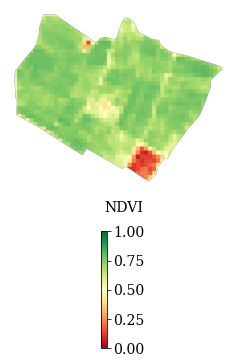

In [19]:
extent = 0.0005
zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]

variable='NDVI'
fig = plt.figure(figsize=(4, 5))
axs = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

cartoee.add_layer(axs, img_productos.select(variable), dims=1000, region=zoom_region, vis_params=vis_params_ndvi)

cartoee.add_colorbar(axs, vis_params=vis_params_ndvi, loc='bottom', posOpts=[0.45, -0.2, 0.02, 0.325], tick_font_size=14)
axs.text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, variable, fontsize=14)

axs.axis('off')

plt.show()

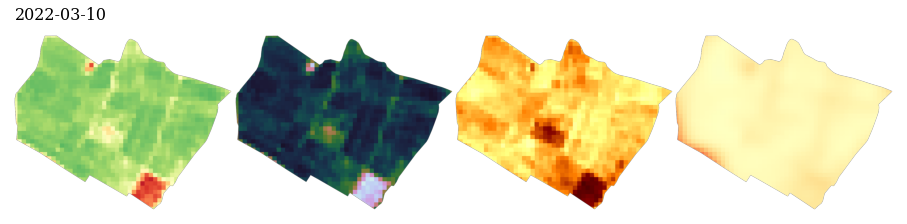

In [9]:
extent = 0.0005
zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]

fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(ncols=4, wspace=-0.05)
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

left = 0.45 # 0.875
bottom = -0.2
width = 0.02 # 0.02
height = 0.325 # 0.125
dims = 1000

axs[0].text(-79.7872, -6.594549+2*extent, img_date_format2, fontsize=16)

variable = 'NDVI'
cartoee.add_layer(axs[0], img_productos.select(variable), dims=dims, region=zoom_region, vis_params=vis_params_ndvi)
# cartoee.add_colorbar(axs[0], vis_params=vis_params_ndvi, loc='right', posOpts=[left, 0.715, width, height], tick_font_size=14)
# axs[0].text(-79.77332525015065+2*extent, -6.5956, variable, fontsize=12)

# cartoee.add_colorbar(axs[0], vis_params=vis_params_ndvi, loc='right', posOpts=[0.2, bottom, width, height], tick_font_size=14)
# axs[0].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, variable, fontsize=14)

axs[0].axis('off')


variable = 'LAI'
cartoee.add_layer(axs[1], img_productos.select(variable), dims=dims, region=zoom_region, vis_params=vis_params_lai)
# cartoee.add_colorbar(axs[1], vis_params=vis_params_lai, loc='right', posOpts=[left, 0.522, width, height], tick_font_size=14)
# axs[1].text(-79.77332525015065+2*extent, -6.5956, variable, fontsize=12)

# cartoee.add_colorbar(axs[1], vis_params=vis_params_lai, loc='right', posOpts=[0.38, bottom, width, height], tick_font_size=14)
# axs[1].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'IAF', fontsize=14)

axs[1].axis('off')


variable = 'albedo'
cartoee.add_layer(axs[2], img_productos.select(variable), dims=dims, region=zoom_region, vis_params=vis_params_alb)
# cartoee.add_colorbar(axs[2], vis_params=vis_params_alb, loc='right', posOpts=[left, 0.325, width, height], tick_font_size=14)
# axs[2].text(-79.77332525015065+2*extent, -6.5956, 'Albedo', fontsize=12)

# cartoee.add_colorbar(axs[2], vis_params=vis_params_alb, 
#                      loc='right', 
#                      posOpts=[0.56, bottom, width, height], 
#                      tick_font_size=14,
#                      ticks=[0, 0.1, 0.17, 0.25])
# axs[2].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, 'Albedo', fontsize=14)

axs[2].axis('off')


variable = 'Ts_c'
cartoee.add_layer(axs[3], img_productos.select('Ts_c'), dims=dims, region=zoom_region, vis_params=vis_params_ts)
# cartoee.add_colorbar(axs[3], vis_params=vis_params_ts, loc='right', posOpts=[left, 0.135, width, height], tick_font_size=14)
# axs[3].text(-79.77332525015065+2*extent, -6.5956, 'Ts', fontsize=12)

# cartoee.add_colorbar(axs[3], vis_params=vis_params_ts, loc='right', posOpts=[0.74, bottom, width, height], tick_font_size=14)
# axs[3].text(-79.78719338866794+12*extent,-6.605665317455976-4*extent, variable, fontsize=14)

axs[3].axis('off')


# plt.savefig(f'{img_date_format2}_horz_productos.jpg', bbox_inches='tight', pad_inches=.1)


plt.show()

### Analizando indices y albedo

#### Albedo

In [12]:
# Inputs iniciales

save_files = False
plot_balance_comp = False
index = 3 # Imagen Landsat: 0 1 Enero, 2 Marzo, 3 Junio 
lai_method = 2

# --------------------------------------------------------------------

img_id = ids[index] 
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_rgb = img_toa.clip(predios_agricolas)

# Fechas 
img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()
fecha = img_date_format2


# Procesar Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem, lai_method=lai_method) # roi: Ferreñafe

print(f'Productos y Rn de imagen {img_date_format2} procesada!')

# Productos 
img_productos_clipped = img_productos.clip(predios_agricolas)

img_albedo = img_productos_clipped.select('albedo')

Productos y Rn de imagen 2022-06-14 procesada!


In [11]:
get_stats(img_albedo, fcol_parcelas, 30)

{'max': {'albedo': 0.21020944539759853},
 'mean': {'albedo': 0.1565055475341514},
 'median': {'albedo': 0.16257401467215046},
 'min': {'albedo': 0.038788440474532886},
 'mode': {'albedo': 0.16351827917944203},
 'stdDev': {'albedo': 0.03066309932264867}}

### Revisando Rn

In [25]:
# Imagen Landsat seleccionada por index
img_id = ids[1] # 3 para Marzo, 7 para Junio
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)

img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

print(f'Rn de imagen {img_date_format2} procesada!')

# Producir tabla con valores de los flujos [W/m^2] necesarios para obtener Radiación Neta 
print('\nR_n_stats_df')
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)
display(R_n_stats_df) 

# Producir tabla de estadísticos sobre los productos elaborados
print('img_prod_stats_df')
img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index', dtype='float')#.round(3)
display(img_prod_stats_df)

Rn de imagen 2022-01-13 procesada!

R_n_stats_df


,R_l_in,R_l_out,R_n,R_s_in
max,355.41,433.21,703.83,849.49
mean,329.46,402.74,622.19,799.22
median,327.38,400.38,623.45,799.13
min,318.57,390.23,531.81,760.33
mode,325.90,397.13,636.55,799.13
stdDev,7.03,8.24,27.38,12.54


img_prod_stats_df


,LAI,NDVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,1.458407,0.642031,26.020418,299.170418,0.206884,0.896870,0.985000,0.985000,6.230337,0.671265
mean,0.457056,0.173278,20.384504,293.534504,0.111805,0.843806,0.956587,0.972369,1.693220,0.671146
median,0.417615,0.154073,19.918063,293.090585,0.109039,0.843791,0.954461,0.971463,1.860348,0.671145
min,-0.230326,-0.148500,17.944078,291.094078,0.056112,0.802741,0.950872,0.970288,0.000000,0.671052
mode,0.355498,0.126808,19.600610,292.657142,0.114780,0.839195,0.953998,0.971162,0.930388,0.671135
stdDev,0.260620,0.122002,1.543292,1.543292,0.030234,0.013283,0.007328,0.003186,0.962314,0.000038


### Parámetros de parte iterativa

#### Evaluando Zom

In [ ]:
# Evaluando valores de Zom

# Flat model momemtum roughnes length
# img_lai < 0.2778 -> Z_om = 0.005 # represents roughness typical of bare agricultural soils
# img_lai >= 0.2778 -> Z_om = 0.018*img_lai
img_zom1 = img_lai.where(img_lai.gte(0.2778), img_lai.multiply(0.018)).where(img_lai.lt(0.2778), 0.005).rename('Z_om')
display(get_stats(img_zom1, predios_agricolas, 30))

# Evaluando corrección por dem
# Adjusting momentum roughness length for slopes
img_zom2 = img_zom1.where(img_slope.gte(5), img_slope.subtract(5).divide(20).add(1).multiply(img_zom1))
display(get_stats(img_zom2, predios_agricolas, 30))

img_ustar = img_zom1.expression('0.41*u_200*1/(log(200/zom))',
                                {'u_200':u_200,
                                 'zom': img_zom1}).rename('u_star')

# img_rah = img_ustar.multiply(0.41).pow(-1).multiply(math.log(2/0.1))
img_rah = img_ustar.expression('log(2/0.1)/(img_ustar*0.41)', {'img_ustar':img_ustar})

display(get_stats(img_rah, predios_agricolas, 30))

In [ ]:
vis_zom = {'min':0.005,
           'max':0.02328919941034575,
           'palette':cmp.get_palette('RdYlBu_r')}

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_zom1, vis_zom, 'img_zom1')
Map.addLayer(img_slope.gte(5), {}, 'img_slope_gte5')
Map.addLayer(img_zom2, vis_zom, 'img_zom2', opacity=0.8)
Map

#### Parte iterativa

**Longitud de la rugosidad que gobierna la transferencia de momentum / Momentum roughness length $z_{om}$ [m]**

Measure of the form drag and skin friction for the layer of air that interacts with the surface. 

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

In [ ]:
# img_lai.select('LAI').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# Momentum roughness length z_om (m) - Tasumi (2003)
# z_om = img_lai.select('LAI').multiply(0.018).rename('z_om')
# z_om.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# @markdown Visualización: LAI y NDVI

# # NDVI > 0 
# img_ndvi_gt0 = img_ndvi.updateMask(img_ndvi.select('NDVI').gt(0)).select('NDVI')

# Map = geemap.Map(height='800px') 
# Map.centerObject(roi, 11)

# # Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

# Map.addLayer(img_toa, vis_rgb, 'img_toa')
# Map.addLayer(img_lai.select('LAI'), vis_ndvi, 'img_lai')
# Map.addLayer(img_ndvi.select('NDVI'), vis_ndvi, 'img_ndvi')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')

# Map.addLayer(empty, {}, 'Chongoyape')
# Map.addLayer(empty2, {}, 'Chongoyape_caja')

# Map

**Velocidad de viento a la altura w $u_w$ $[\text{m s}^{-1}]$**

Datos de estación Vista Florida 2021-2022. Inicio: `1/10/2021`

In [ ]:
# 8 Imágenes seleccionadas
# ids = [
#     'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
#       ]

fechas_imgs = []

for img_id in ids:
    img_ee = ee.Image(img_id)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    fechas_imgs.append(img_date)

# fechas_imgs = '2021-12-12',
#  '2022-01-13',
#  '2022-01-29',
#  '2022-03-10',
#  '2022-04-03',
#  '2022-05-21',
#  '2022-05-29',
#  '2022-06-14']

In [ ]:
ruta_csv = 'EE_Vista_Florida.csv'
df_estacion_vf = pd.read_csv(ruta_csv, na_values='---') 
df_estacion_vf.Date = pd.to_datetime(df_estacion_vf.Date, format='%d/%m/%Y')
# df_estacion_vf

# Cambio de formato en columna Time de object a numeric (para visualizar mejor con matplotlib)
df_prueba = df_estacion_vf.copy()
df_prueba['Time'] = pd.to_numeric(df_prueba['Time'].str.replace(":", "."))

# Extraemos los datos de la estación para las fechas de existencia de imagen satelital
datos_hora_imagen = df_prueba[df_prueba['Date'].isin(fechas_imgs)]
# datos_hora_imagen

# Visualizamos y comparamos los dataframes según la hora de filtrado
display(datos_hora_imagen[datos_hora_imagen['Time']==10.30])
display(datos_hora_imagen[datos_hora_imagen['Time']==11.00])

In [ ]:
fecha = img_date
hora = 10.30

print(fecha)
filtrado = datos_hora_imagen[(datos_hora_imagen['Date']==fecha) & (datos_hora_imagen['Time']==hora)]
filtrado

In [ ]:
datos_hora_imagen[(datos_hora_imagen['Date']==fecha) & (datos_hora_imagen['Time']>=10)].head(13)

In [ ]:
filtrado_ws = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==10.30)]['Wind Speed']
    .values[0]
)

print(filtrado_ws) # [km/h]

filtrado_et = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==11)]['ET']
    .values[0]
)
print(filtrado_et)

**Código pasado: Lectura de archivo .csv y visualización con plotly**

In [ ]:
# @markdown Generar reporte de velocidad de viento

# # Lectura de datos de la estación meteorológica Tinajones
ruta_csv = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/Tinajones_datos_met_2021.csv'

# df_tinajones = pd.read_csv(ruta_csv, na_values='S/D')
df_tinajones.FECHA = pd.to_datetime(df_tinajones.FECHA, format='%d/%m/%Y')

vel_viento_15hr = df_tinajones[df_tinajones['HORA']=='15:00']

# # Lectura de datos del reporte de imágenes satelitales generado con Earth Engine
ruta_reportel8 = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/reporteL8_RAW_2021.csv'

# df_reportel8 = pd.read_csv(ruta_reportel8)
fechas_reportel8 = df_reportel8['Fecha Corta'].tolist()

vel_viento_15hr = vel_viento_15hr[vel_viento_15hr['FECHA'].isin(fechas_reportel8)]
vel_viento_15hr

In [ ]:
vel_viento_ruta = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/vel_viento_15hr.csv'
vel_viento_15hr = pd.read_csv(vel_viento_ruta)
vel_viento_15hr

In [ ]:
# @markdown Visualización de datos de velocidad de viento [m/s]
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
         vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'], 
         'd-')

plt.title('Velocidad del viento 15:00 hrs'), 
plt.ylabel('VELOCIDAD DEL VIENTO [m/s]')

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid();

In [ ]:
import plotly.graph_objects as go

# @markdown Gráfica con Plotly: Sentinel-2, Landsat 8 y Landsat 9

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
               y=vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'],
               name='Sentinel-2', 
              #  marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f} m/s',
               line = dict(width=2)#, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Velocidad del viento 15:00 hrs - Estación Tinajones'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    # xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)] 
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.3, y=1.10),
    legend_orientation='h',
    # https://plotly.com/python/reference/layout/#layout-legend-orientation
    )

# Nombres en ejes
fig.update_yaxes(title_text='VELOCIDAD DEL VIENTO [m/s]',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
# fig.write_html("prueba_plotly.html")

**Wind speed at an assumed blending height (200 m) above the weather station $u_{200}$ [m s-1]**

Is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

In [ ]:
# Velocidad del viento medido por estación meteorológica a las 10:30 [m/s]
u_w = filtrado_ws*10/36 # filtrado_ws en km/hr -> m/s

z_omw = 0.12*0.15  # z_omw = 0.12*h donde h es la altura del grass de la estación met (relativo a cada estación)
z_x = 2.5          # altura del equipo que mide la velocidad del viento, varía de 2 a 2.80m (relativo a cada estación)

u_200 = u_w*math.log(200/z_omw)/math.log(z_x/z_omw)
u_200 # (m/s)

**Friction velocity $u*$ [m s-1]**

is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ k \; u_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.
- $k$ : von Karman's constant **(0.41)**. 

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation.

Más info:
- [Log wind profile](https://en.wikipedia.org/wiki/Log_wind_profile#cite_note-1): The log wind profile is a semi-empirical relationship commonly used to describe the vertical distribution of horizontal mean wind speeds within the lowest portion of the planetary boundary layer.
- [Friction velocity - Shear velocity](https://en.wikipedia.org/wiki/Shear_velocity)
- [Roughness length $(z_0)$](https://en.wikipedia.org/wiki/Roughness_length): Is a corrective measure to account for the effect of the roughness of a surface on wind flow. That is, the value of the roughness length depends on the terrain.

In [ ]:
# u*1
k_const = 0.41
u_star = k_const*u_200/(math.log(200/z_omw))
u_star

**Aerodynamic resistance $r_{ah}$ [s m-1] between two near surface heights $z_1$ and $z_2$**

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$